# Segmentation of Cell Nuclei Using Otsu Thresholding

### Introduction

Accurate segmentation of cell nuclei in fluorescence microscopy images is an essential step in many biomedical image analysis pipelines. Manual segmentation is impractical for large datasets, as it is time-consuming, subjective, and non-reproducible. Automated thresholding methods such as **Otsu’s method** provide an efficient way to segment cell nuclei by automatically selecting an intensity threshold that separates foreground (nuclei) from background.

In this project, we implemented and evaluated **global** and **local Otsu thresholding methods** for cell nuclei segmentation, as required by Project 3 of the Biomedical Image Analysis topic. Furthermore, we applied these methods to three different microscopy datasets:

- **N2DH-GOWT1**: GFP-labeled mouse embryonic stem cells.
- **N2DL-HeLa**: H2B-GFP-labeled HeLa cells.
- **NIH3T3**: Mouse fibroblast cells with challenging bright artifacts.

### Objectives

The main objectives of our work were:

- To implement global Otsu thresholding for cell nuclei segmentation.
- To extend the implementation to local Otsu thresholding using a sliding window approach.
- To quantitatively evaluate the segmentation performance using the Dice coefficient against manually annotated ground-truth masks.
- To verify our implementations by comparing them to the `scikit-image` package.
- To investigate the application of Multi-Otsu thresholding on the NIH3T3 dataset to reduce the effect of extreme brightness artifacts (“flashes”).
- To investigate the enhancement of our output by implementig pre processing methods.

### Notebook Structure

The notebook is organized as follows:

1. **Environment Setup**: Configuration for reproducibility and importing necessary modules.
2. **Loading Images & Ground Truth**: Reading representative images and masks from all datasets.
3. **Global and Local Thresholding**: Applying both our implementations and package methods.
4. **Dice Score Computation**: Calculating scores for quantitative assessment.
5. **Extended Analysis with Multi-Otsu**: Addressing artifacts in NIH3T3 with multi-thresholding.
6. **Extended Analysis with pre prcessing**: Applying and analysing Otsu outputs of multiple pre processing methods.
6. **Results & Visualization**: Presenting outcomes using comparative plots.
7. **Conclusion**: Summarizing findings and practical insights.

## 1. Environment Setup

In this section, we configure the environment to ensure that our custom Python modules can be imported from anywhere in the notebook. By dynamically setting the project root and adding it to the Python path, we guarantee reproducibility and avoid path-related import errors. This setup is essential for maintaining a clean, modular, and portable project structure.

In [1]:
import os
import sys

# Set the project root so we can import our custom modules from anywhere in the notebook
script_dir = os.getcwd()
project_root = os.path.abspath(script_dir)

if project_root not in sys.path:
    sys.path.insert(0, project_root)

## 2. Loading Images & Ground Truth

To perform a meaningful evaluation of our segmentation algorithms, it is essential to work with representative images from each of the three datasets provided: GOWT1, HeLa, and NIH3T3. This section demonstrates how we load and visualize both the raw images and their corresponding manually segmented ground truth masks.

**Loading and Visualizing Raw Images**

First, we use the custom utility `find_and_load_image` to locate and load representative grayscale images from each dataset. By plotting these side by side, we gain a visual overview of the differences in appearance and image quality between the datasets, which is critical for understanding the challenges of automated segmentation.

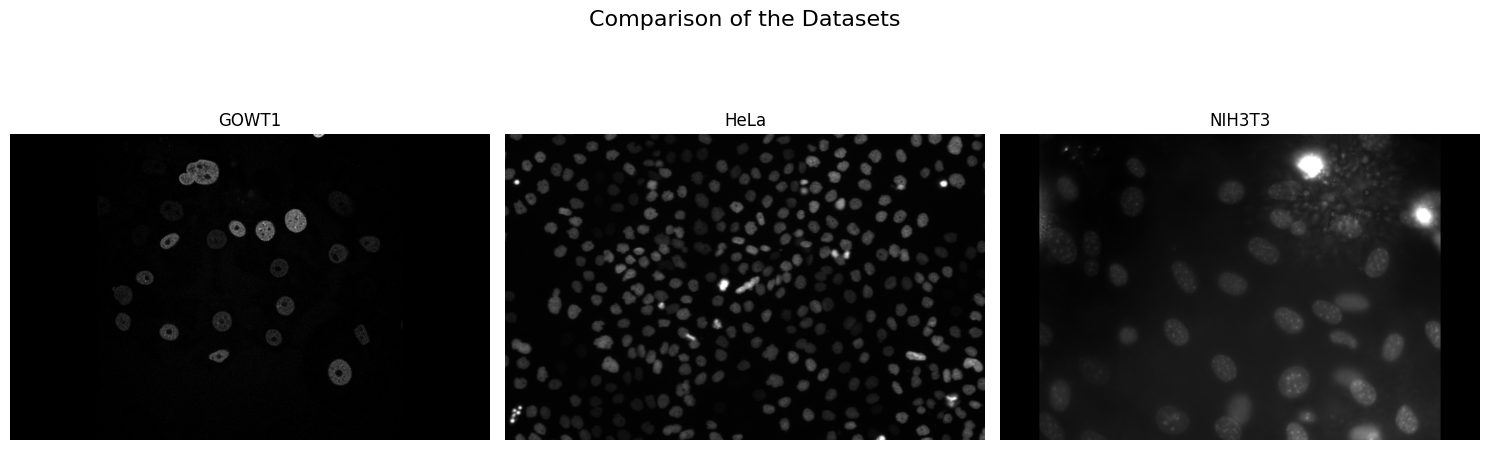

In [2]:
# Load representative images from each dataset by filename
from src.find_image import find_and_load_image

img_gowt1 = find_and_load_image("t01.tif")       # N2DH-GOWT1 example image
img_hela = find_and_load_image("t75.tif")        # N2DL-HeLa example image
img_nih3t3 = find_and_load_image("dna-33.png")   # NIH3T3 example image

# Plot the selected images side by side for visual comparison
from src.show_imgs import plot_images_fixed_size

images_img = [img_gowt1, img_hela, img_nih3t3]
titles_img = ["GOWT1", "HeLa", "NIH3T3"]

plot_images_fixed_size(images_img, titles=titles_img, main_title="Comparison of the Datasets")

**Loading and Visualizing Ground Truth Masks**

Next, we load the corresponding ground truth masks for the previously loaded images. These masks represent the expert-annotated segmentation of the cell nuclei and serve as the reference for evaluating our segmentation methods. Plotting the masks alongside the original images provides an immediate qualitative impression of the segmentation targets in each dataset.

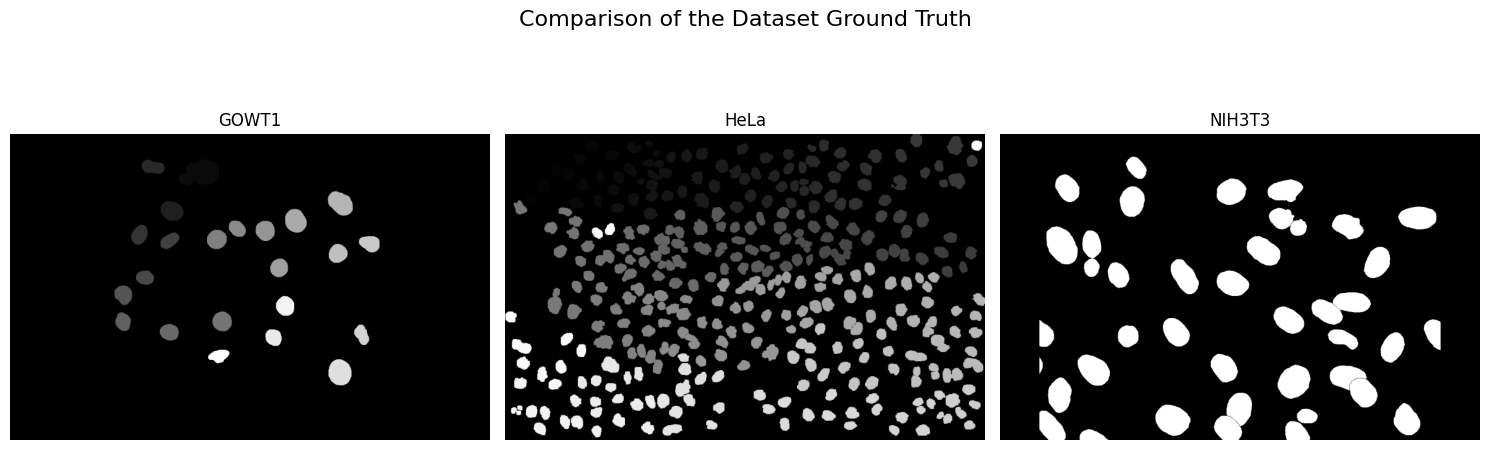

In [3]:
# Load corresponding manually annotated ground-truth masks for each example image
gt_gowt1 = find_and_load_image("man_seg01.tif")  # Ground truth for GOWT1
gt_hela = find_and_load_image("man_seg75.tif")  # Ground truth for HeLa
gt_nih3t3 = find_and_load_image("33.png")       # Ground truth for NIH3T3

# Plot the ground-truth masks side by side for visual comparison
images_gt = [gt_gowt1, gt_hela, gt_nih3t3]
titles_gt = ["GOWT1", "HeLa", "NIH3T3"]

plot_images_fixed_size(images_gt, titles=titles_gt, main_title="Comparison of the Dataset Ground Truth")

## 3. Global and Local Thresholding

In this section, we apply our own implementations for global and local thresholding, key techniques for segmenting cell nuclei based on intensity differences.

**Global Otsu Thresholding (Our Implementation)**

We first apply our own implementation of Otsu’s global thresholding algorithm (`otsu_threshold_skimage_like`) on a representative GOWT1 image. This method automatically finds an optimal global threshold value that separates foreground (cell nuclei) from background based on maximizing inter-class variance in the grayscale histogram. The result is then compared against the ground truth.

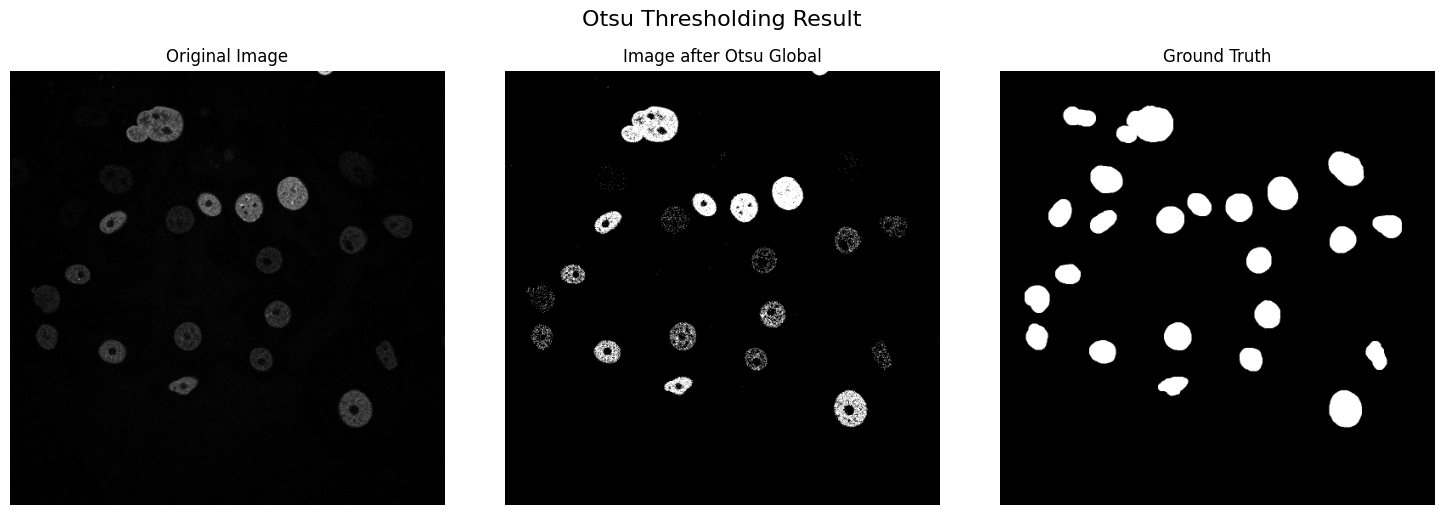

In [4]:
# Apply global Otsu thresholding to the GOWT1 image
from src.Complete_Otsu_Global import otsu_threshold_skimage_like

threshold = otsu_threshold_skimage_like(img_gowt1)
img_gowt1_otsu_global = (img_gowt1 > threshold).astype(int)  # Binarized image

# Visualize the original image, the thresholded result, and the ground truth side by side
plot_images_fixed_size(
    images=[img_gowt1, img_gowt1_otsu_global, (gt_gowt1 > 0).astype(int)],
    titles=["Original Image", "Image after Otsu Global", "Ground Truth"],
    main_title="Otsu Thresholding Result"
)


**Local Otsu Thresholding (Our Implementation)**

To handle images with non-uniform illumination, we extend Otsu’s method to a local variant using our own `local_otsu` implementation. This technique calculates a local threshold for each pixel within a sliding window, resulting in better segmentation performance in challenging images with shading artifacts or heterogeneous lighting.

**Important Note:** This implementation is computationally intensive and takes a long time to run on high-resolution images even with smal window radii like 15. Therefore, it may not be practical for quick notebook execution or large-scale datasets. For quick notebook execution skip to the next code cell which contains the output of this implimantation.

In [5]:
# Apply local Otsu thresholding with a specified radius (computationally intensive)
import numpy as np
from src.Otsu_Local import local_otsu

thresholds_local = local_otsu(img_gowt1, radius=15)
img_gowt1_otsu_local = (img_gowt1 > thresholds_local).astype(int)  # Binarized image

# Save the locally thresholded result for reproducibility and later analysis
np.save(
    os.path.join(project_root, "output", "img_gowt1_otsu_local"), 
    img_gowt1_otsu_local
)

Processing row 1/1024...
Processing row 51/1024...
Processing row 101/1024...
Processing row 151/1024...
Processing row 201/1024...
Processing row 251/1024...
Processing row 301/1024...
Processing row 351/1024...
Processing row 401/1024...
Processing row 451/1024...


KeyboardInterrupt: 

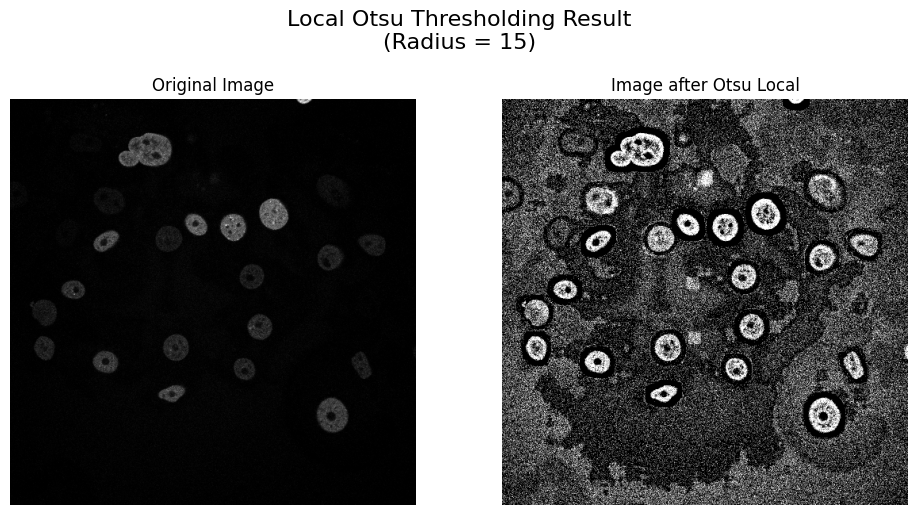

In [ ]:
# Load the previously saved locally thresholded GOWT1 image
img_gowt1_otsu_local = np.load(os.path.join(project_root, "output", "img_gowt1_otsu_local.npy"))

# Display the original image alongside the local Otsu thresholding result
plot_images_fixed_size(
    images=[img_gowt1, img_gowt1_otsu_local],
    titles=["Original Image", "Image after Otsu Local"],
    main_title="Local Otsu Thresholding Result\n(Radius = 15)"
)

## 4. Dice Score Computation

In this section, we compute Dice scores to quantitatively evaluate the performance of the global and local Otsu segmentation methods with `dice_score`. The Dice coefficient measures the overlap between the predicted segmentation mask and the ground truth, providing a score between 0 (no overlap) and 1 (perfect match).

**Single Image Dice Score Computation:**

We begin by computing Dice scores for a single representative image (GOWT1) using both the global and local Otsu thresholding results. This provides an immediate indication of how each segmentation method performs on an example case before applying them across the full datasets.


In [ ]:
# Compute Dice scores by comparing the binarized images to the ground truth
from src.Dice_Score import dice_score

dice_score_gowt1_global = dice_score(img_gowt1_otsu_global, gt_gowt1)  # Global Otsu
dice_score_gowt1_local = dice_score(img_gowt1_otsu_local, gt_gowt1)    # Local Otsu

# Output the Dice scores for both methods
print("Dice Score Otsu Global:", dice_score_gowt1_global)
print("Dice Score Otsu Local:", dice_score_gowt1_local)

Dice Score Otsu Global: 0.5705017182130584
Dice Score Otsu Local: 0.28915016099131624


**Loading All Dataset Images:**

Next, we load all images and their corresponding ground truth masks from the three datasets (N2DH-GOWT1, N2DL-HeLa, NIH3T3) with the funktions `load_n2dh_gowt1_images`,`load_n2dl_hela_images` and `load_nih3t3_images`. Access to the complete data is essential for a robust, dataset-wide evaluation of segmentation performance.

In [8]:
# Import dataset loading functions from the project-specific src/ directory
from src.imread_all import load_n2dh_gowt1_images, load_n2dl_hela_images, load_nih3t3_images

# Load grayscale images and corresponding ground-truth masks for each dataset
imgs_N2DH_GOWT1, gts_N2DH_GOWT1, img_paths_N2DH_GOWT1, gt_paths_N2DH_GOWT1 = load_n2dh_gowt1_images()
imgs_N2DL_HeLa, gts_N2DL_HeLa, img_paths_N2DL_HeLa, gt_paths_N2DL_HeLa = load_n2dl_hela_images()
imgs_NIH3T3, gts_NIH3T3, img_paths_NIH3T3, gt_paths_NIH3T3 = load_nih3t3_images()

# Aggregate image paths for reference or result mapping
all_image_paths = [img_paths_N2DH_GOWT1, img_paths_N2DL_HeLa, img_paths_NIH3T3]

**Global Otsu Dice Scores on All Datasets:**

We then calculate Dice scores across the entire datasets using our own global Otsu implementation. Using the `calculate_dice_scores_global`function we produces a distribution of Dice scores reflecting the performance of global thresholding on each dataset.

In [11]:
# Compute Dice scores after applying global Otsu thresholding for each dataset
from src.Dice_Score_comparison import calculate_dice_scores_global

dice_all_gowt1_global = calculate_dice_scores_global(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
dice_all_hela_global = calculate_dice_scores_global(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_all_nih_global = calculate_dice_scores_global(imgs_NIH3T3, gts_NIH3T3)

# Convert NumPy floats to native Python floats for cleaner printed output
dice_all_gowt1_global = [float(score) for score in dice_all_gowt1_global]
dice_all_hela_global = [float(score) for score in dice_all_hela_global]
dice_all_nih_global = [float(score) for score in dice_all_nih_global]

# Combine Dice scores from all datasets into a single list
dice_all_global = dice_all_gowt1_global + dice_all_hela_global + dice_all_nih_global

# Print Dice scores for each dataset in a clear, human-readable format
print("GOWT1_Scores_global =\n", list(dice_all_gowt1_global))
print("HeLa_Scores_global =\n", list(dice_all_hela_global))
print("NIH3T3_Scores_global =\n", list(dice_all_nih_global))

GOWT1_Scores_global =
 [0.5705017182130584, 0.32258217915948406, 0.568002229254991, 0.6271474725294504, 0.6502180828858916, 0.6615248976783192]
HeLa_Scores_global =
 [0.6923060104510571, 0.649295517879001, 0.7760944676315427, 0.7761119912979735]
NIH3T3_Scores_global =
 [0.9128436675562167, 0.8845252721173281, 0.8225479821936802, 0.758336987687637, 0.7528567225654604, 0.647632667167185, 0.6466958730507323, 0.7237186625334818, 0.03500481623642597, 0.46518566600901357, 0.0, 0.6762501531852865, 0.00026339009389856846, 0.5757554586315079, 0.6165448260228947, 0.07605520913993832, 0.07186834004262373, 0.7925039681767514]


**Local Otsu Dice Scores on All Datasets (Our Implementation):**

To compare with the global approach, we also compute Dice scores across all images using our own implementation of local Otsu thresholding with the function `calculate_dice_scores_local`.
**Note**: This step can be very time-consuming due to the computational complexity of sliding-window thresholding. May consider using the loaded outputs one code cell below.


In [ ]:
# Compute Dice scores for local Otsu thresholding (radius=15) on each dataset (computationally intensive)
from src.Dice_Score_comparison import calculate_dice_scores_local
import numpy as np

dice_all_gowt1_local = calculate_dice_scores_local(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
dice_all_hela_local = calculate_dice_scores_local(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_all_nih_local = calculate_dice_scores_local(imgs_NIH3T3, gts_NIH3T3)

# Convert NumPy floats to native Python floats for clearer printed output
dice_all_gowt1_local = [float(score) for score in dice_all_gowt1_local]
dice_all_hela_local = [float(score) for score in dice_all_hela_local]
dice_all_nih_local = [float(score) for score in dice_all_nih_local]

# Concatenate Dice scores from all datasets into a single list
dice_all_local = dice_all_gowt1_local + dice_all_hela_local + dice_all_nih_local

# Save all Dice scores as .npy files to avoid recomputation in future runs
np.save(os.path.join(project_root, "output", "dice_all_gowt1_local"), dice_all_gowt1_local)
np.save(os.path.join(project_root, "output", "dice_all_hela_local"), dice_all_hela_local)
np.save(os.path.join(project_root, "output", "dice_all_nih_local"), dice_all_nih_local)
np.save(os.path.join(project_root, "output", "dice_all_local"), dice_all_local)

# Print Dice scores for each dataset in a clear, human-readable format
print("GOWT1_Scores_local =\n", list(dice_all_gowt1_local))
print("HeLa_Scores_local =\n", list(dice_all_hela_local))
print("NIH3T3_Scores_local =\n", list(dice_all_nih_local))

Processing row 1/1024...
Processing row 51/1024...


KeyboardInterrupt: 

In [ ]:
# Load saved Dice scores for each dataset from .npy files
dice_all_gowt1_local = np.load(os.path.join(project_root, "output", "dice_all_gowt1_local.npy"))
dice_all_hela_local = np.load(os.path.join(project_root, "output", "dice_all_hela_local.npy"))
dice_all_nih_local = np.load(os.path.join(project_root, "output", "dice_all_nih_local.npy"))

# Convert to plain Python floats for consistent and readable output
dice_all_gowt1_local = [float(score) for score in dice_all_gowt1_local]
dice_all_hela_local = [float(score) for score in dice_all_hela_local]
dice_all_nih_local = [float(score) for score in dice_all_nih_local]

# Print Dice scores for each dataset in a clear, human-readable format
print("GOWT1_Scores_local =\n", list(dice_all_gowt1_local))
print("HeLa_Scores_local =\n", list(dice_all_hela_local))
print("NIH3T3_Scores_local =\n", list(dice_all_nih_local))


GOWT1_Scores_local =
 [0.28915016099131624, 0.16063829075758015, 0.22105149983872702, 0.2231858373710903, 0.3088252523054779, 0.30119415014900364]
HeLa_Scores_local =
 [0.127401800392217, 0.22748756252516544, 0.8096747709543749, 0.8140793571650516]
NIH3T3_Scores_local =
 [0.29039299624199894, 0.33118018193464527, 0.4176239930846999, 0.4371394982478085, 0.3701623597067227, 0.3284172674518776, 0.43645741459967713, 0.5000010028581457, 0.4155832945477366, 0.35224958286077346, 0.38652755251439025, 0.3937666853205875, 0.33780649515453676, 0.499008725175988, 0.40156051427417766, 0.36125789077430936, 0.3048632763421365, 0.5034307768885828]


## 5. Extended Analysis with Multi-Otsu

In this section, we investigate the use of Multi-Otsu thresholding as a potential strategy to address artifacts in the NIH3T3 dataset, specifically, the bright "flashes" observed in some images. These artifacts can disrupt standard Otsu thresholding by skewing the histogram, leading to poor segmentation results.

To explore this, we apply Multi-Otsu thresholding with three classes to separate the image into dark background (class 0), an intermediate intensity range (class 1), and bright artifacts (class 2). We then designate only class 1 (foreground nuclei) as the actual object of interest while treating both class 0 and class 2 as background (`apply_multiotsu_mask_class1`). This approach effectively excludes extreme intensity values (flashes) from the foreground mask.

We visualize the original NIH3T3 image, the Multi-Otsu segmentation result, the global Otsu segmentation result for comparison, and the ground truth side by side to qualitatively assess the differences.

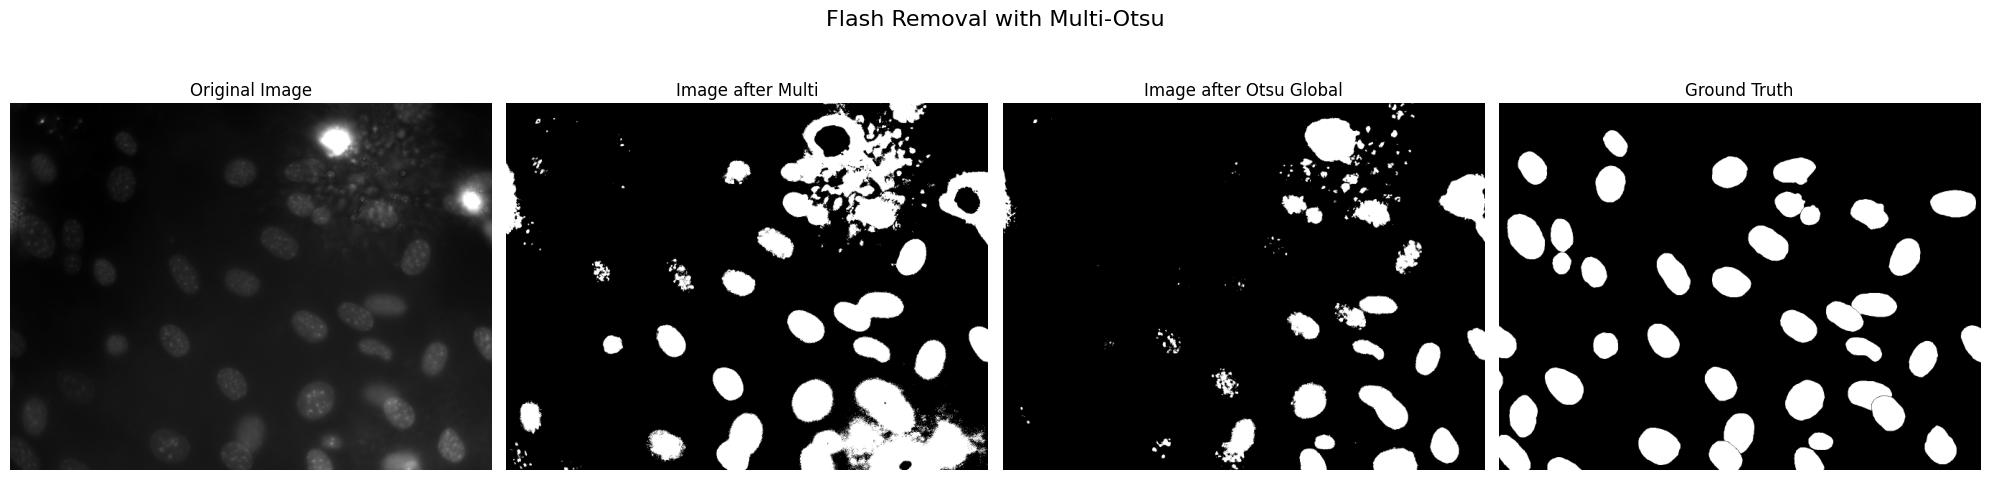

In [ ]:
# Apply Multi-Otsu thresholding, selecting only class 1 as foreground
from src.multi import apply_multiotsu_mask_class1

img_nih3t3_multi = apply_multiotsu_mask_class1(img_nih3t3).astype(int)

# Apply global Otsu thresholding for comparison
threshold_nih3t3_global = otsu_threshold_skimage_like(img_nih3t3)
img_nih3t3_otsu_global = (img_nih3t3 > threshold_nih3t3_global).astype(int)

# Visualize the original image, Multi-Otsu result, global Otsu result, and ground truth
plot_images_fixed_size(
    images=[img_nih3t3, img_nih3t3_multi, img_nih3t3_otsu_global, gt_nih3t3],
    titles=["Original Image", "Image after Multi", "Image after Otsu Global", "Ground Truth"],
    main_title="Flash Removal with Multi-Otsu"
)

After generating the segmentations, we quantitatively evaluate the Multi-Otsu approach on the entire NIH3T3 dataset by computing Dice scores for all images. We plot these Dice scores against those obtained from our global Otsu implementation using a scatter plot. Points are colored to indicate whether Multi-Otsu performed better (green), worse (red), or similarly (blue) compared to global Otsu thresholding.

In [6]:
# Import scatterplot function and Multi-Otsu Dice calculation
from src.Plots import scatterplot_without_regression
from src.multi import calculate_multiotsu_dice_scores_class1

# Compute Dice scores for NIH3T3 images using Multi-Otsu (class 1 as foreground)
dice_all_nih_multi = calculate_multiotsu_dice_scores_class1(imgs_NIH3T3, gts_NIH3T3)

# Plot a scatterplot comparing Dice scores from Multi-Otsu and global Otsu thresholding
scatterplot_without_regression(
    dice_all_nih_multi,
    dice_all_nih_global,
    xlabel="Dice Score Multi Otsu",
    ylabel="Dice Score Global Otsu",
    title="Multi vs Global Otsu\nNIH3T3 Dataset",
    label_red="Multi is worse",
    label_green="Multi is better",
    label_blue="equal"
)

NameError: name 'imgs_NIH3T3' is not defined

The results showed that Multi-Otsu thresholding did not lead to consistent improvements; in many cases, it even degraded the segmentation performance due to misclassification of true nuclei pixels as background when intensities overlapped with those of artifacts.
Beacause of that we explored two refinements aiming to mitigate the impact of bright artifacts ("flashes") in the NIH3T3 dataset more effectively:

**1. Multi-Otsu with Cleaning**

Building on the basic Multi-Otsu method, this step implements a cleaning strategy to ignore extremely bright regions (e.g., flashes) even if they fall into the chosen foreground class. The aim is to evaluate whether explicitly excluding overexposed pixels improves segmentation accuracy on NIH3T3 images. We calculate Dice scores for all images using this cleaned mask with the function `calculate_multiotsu_dice_scores_class1_cleaned`and compare them to our global Otsu results.

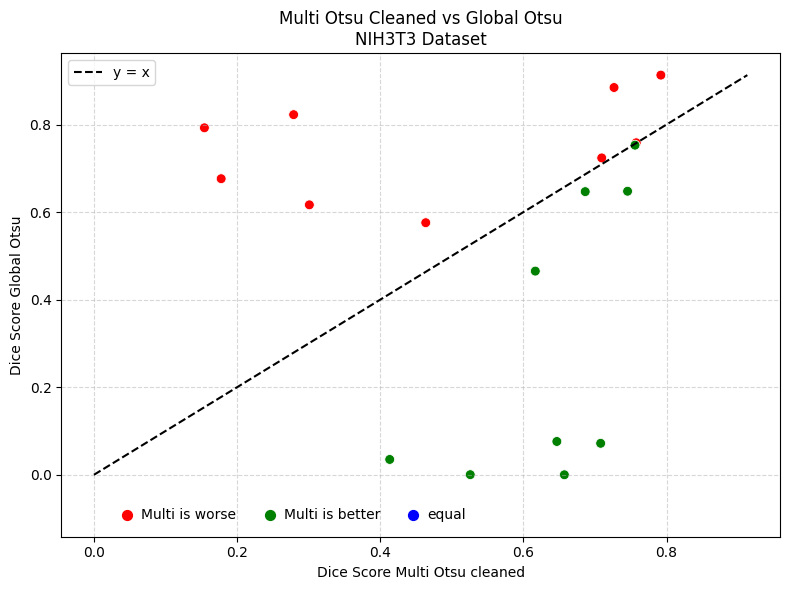

In [ ]:
# Compute Dice scores for NIH3T3 images after applying cleaned Multi-Otsu thresholding
from src.multi import calculate_multiotsu_dice_scores_class1_cleaned

dice_all_nih_multi_cleand = calculate_multiotsu_dice_scores_class1_cleaned(imgs_NIH3T3, gts_NIH3T3)

# Plot a scatterplot comparing cleaned Multi-Otsu Dice scores against global Otsu Dice scores
scatterplot_without_regression(
    dice_all_nih_multi_cleand,
    dice_all_nih_global,
    xlabel="Dice Score Multi Otsu cleaned",
    ylabel="Dice Score Global Otsu",
    title="Multi Otsu Cleaned vs Global Otsu\nNIH3T3 Dataset",
    label_red="Multi is worse",
    label_green="Multi is better",
    label_blue="equal"
)

**2. Multi-Otsu with Cleaning and Small Object Removal**

In this final variant, we further extend the cleaning approach by also removing small connected components after thresholding. The intention is to eliminate isolated noise or residual artifacts that could skew the Dice score. We again compute Dice scores for the NIH3T3 dataset with `calculate_multiotsu_dice_scores_class1_cleaned_remove` and visualize the comparison to the global Otsu method to assess whether these refinements lead to a more consistent improvement.

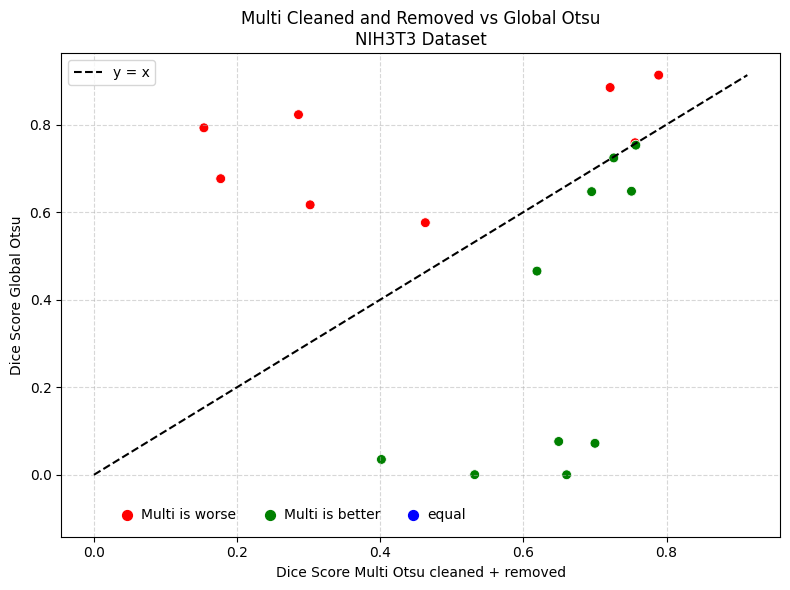

In [ ]:
# Compute Dice scores for NIH3T3 images after cleaned Multi-Otsu thresholding with artifact removal
from src.multi import calculate_multiotsu_dice_scores_class1_cleaned_remove

dice_all_nih_multi_cleand_remove = calculate_multiotsu_dice_scores_class1_cleaned_remove(imgs_NIH3T3, gts_NIH3T3)

# Plot a scatterplot comparing cleaned + artifact-removed Multi-Otsu Dice scores vs global Otsu Dice scores
scatterplot_without_regression(
    dice_all_nih_multi_cleand_remove,
    dice_all_nih_global,
    xlabel="Dice Score Multi Otsu cleaned + removed",
    ylabel="Dice Score Global Otsu",
    title="Multi Cleaned and Removed vs Global Otsu\nNIH3T3 Dataset",
    label_red="Multi is worse",
    label_green="Multi is better",
    label_blue="equal"
)

Despite these refinements, the overall performance trend did not improve significantly: approximately half of the images showed better segmentation with Multi-Otsu, while the other half performed worse. This inconsistency indicates that even with targeted cleaning and artifact removal, Multi-Otsu thresholding does not reliably outperform standard global Otsu on the NIH3T3 dataset. Based on these findings, we decided not to pursue Multi-Otsu-based segmentation further as a solution for flash artifact correction.

## 6. Extended Analysis with Pre-Processing

To explore whether pre-processing can improve the performance of global Otsu thresholding on cell images, we implemented four different pre-processing techniques followed by global Otsu segmentation. The effectiveness of each method was evaluated using the Dice coefficient against manual ground truth segmentations across all datasets.

**Gamma Correction + Otsu Global**  

Gamma correction adjusts the intensity distribution, making dim structures more distinguishable. Using an empirically chosen gamma of 0.6, we first applied gamma correction to the images before thresholding with Otsu's method. 

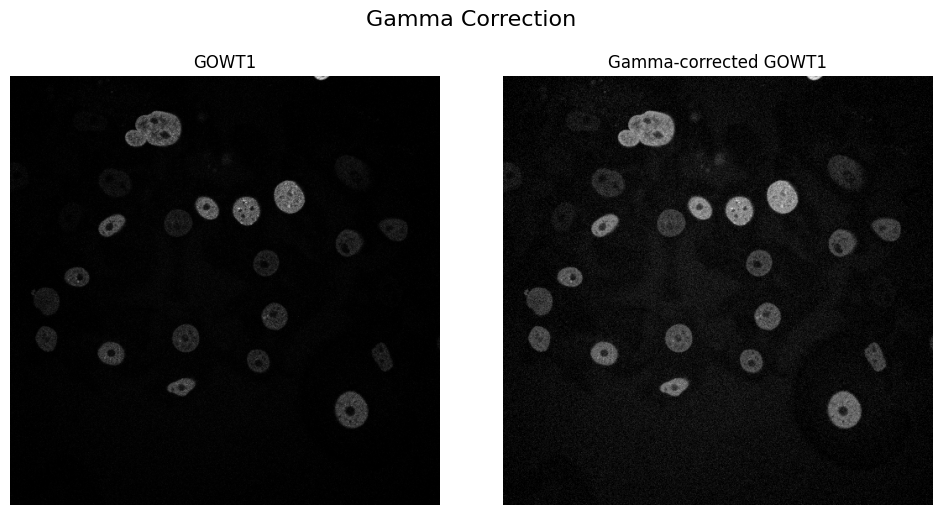

In [ ]:
# Apply gamma correction to enhance contrast in the GOWT1 image
from src.pre_processing import gammacorrection

img_gowt1_gamma = gammacorrection(img_gowt1, gamma=0.6)

# Display the original and gamma-corrected GOWT1 images side by side
images_gamma = [img_gowt1, img_gowt1_gamma]
titles_img_gamma = ["GOWT1", "Gamma-corrected GOWT1"]

plot_images_fixed_size(images_gamma, titles=titles_img_gamma, main_title="Gamma Correction")

In [ ]:
# Import function to apply gamma correction followed by global Otsu thresholding and calculate Dice scores
from src.Dice_Score_comparison import calculate_dice_scores_gamma_global

# Apply gamma correction + global Otsu thresholding on all images and compute Dice scores per dataset
dice_scores_N2DH_GOWT1_gamma_global = calculate_dice_scores_gamma_global(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
dice_scores_N2DL_HeLa_gamma_global = calculate_dice_scores_gamma_global(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_scores_NIH3T3_gamma_global = calculate_dice_scores_gamma_global(imgs_NIH3T3, gts_NIH3T3)

# Concatenate all Dice scores into a single vector for evaluation across datasets
all_dice_scores_gamma_global = (dice_scores_N2DH_GOWT1_gamma_global + dice_scores_N2DL_HeLa_gamma_global + dice_scores_NIH3T3_gamma_global)

In [ ]:
# Import function to plot paired scores and NumPy for indexing
from src.Plots import plot_pairwise_scores
import numpy as np

# Define image labels for each sample across the three datasets
labels = [
    # N2DH-GOWT1
    't01.tif', 't21.tif', 't31.tif', 't39.tif', 't52.tif', 't72.tif', 
    # N2DL-HeLa
    't13.tif', 't52.tif', 't75.tif', 't79.tif',     
    # NIH3T3                  
    'dna-0.png', 'dna-1.png', 'dna-26.png', 'dna-27.png', 'dna-28.png', 'dna-29.png', 
    'dna-30.png', 'dna-31.png', 'dna-32.png', 'dna-33.png', 'dna-37.png', 'dna-40.png', 
    'dna-42.png', 'dna-44.png', 'dna-45.png', 'dna-46.png', 'dna-47.png', 'dna-49.png'                                       
]

# Create x-axis indices corresponding to image labels
file_names = np.arange(len(labels))

# Generate a spaghetti plot comparing Dice scores of global Otsu vs. gamma correction + global Otsu
plot_pairwise_scores(
    file_names, 
    dice_all_global, 
    all_dice_scores_gamma_global, 
    labels=labels, 
    title="Otsu Global vs. Gamma + Otsu Global", 
    xlabel="All Images", 
    legend_labels=("Otsu Global", "Gamma Correction + Otsu Global")
)


NameError: name 'dice_all_global' is not defined

The paired Dice scores showed a clear improvement compared to Otsu global alone, especially for the HeLa dataset (t13-t79). The spaghetti plot indicates that gamma correction consistently increased Dice scores for most images, with some outliers where performance minimally dropped. However, this method's overall stability across datasets demonstrated its potential as a promising pre-processing step.

**Histogram Equalization + Otsu Global**

Histogram equalization redistributes pixel intensities to span the full 0–255 range, enhancing contrast by equalizing the cumulative histogram of the image.

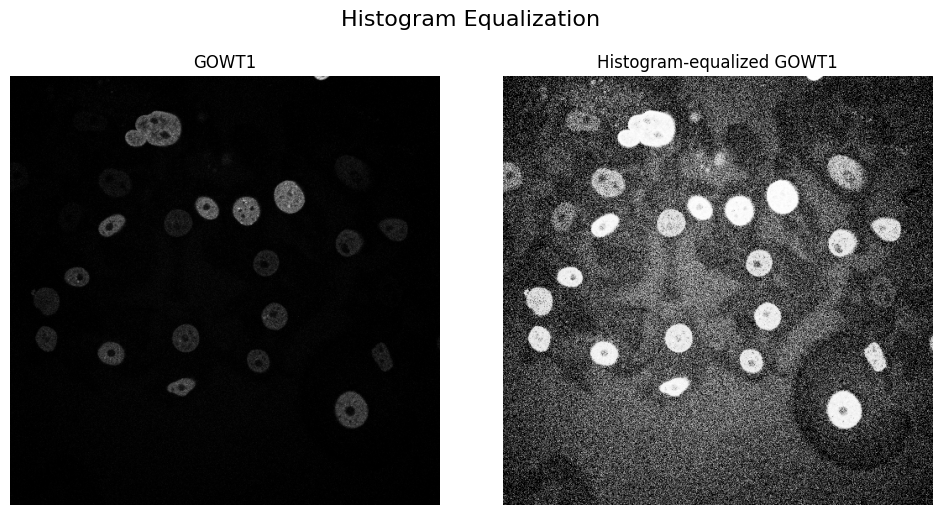

In [ ]:
# Apply histogram equalization to the GOWT1 image to enhance contrast
from src.pre_processing import histogramequalization

img_gowt1_histeq = histogramequalization(img_gowt1)

# Display the original and histogram-equalized images side by side
images_histeq = [img_gowt1, img_gowt1_histeq]
titles_img_histeq = ["GOWT1", "Histogram-equalized GOWT1"]

plot_images_fixed_size(images_histeq, titles=titles_img_histeq, main_title="Histogram Equalization")

In [ ]:
# Import function for histogram equalization followed by global Otsu thresholding and Dice score calculation
from src.Dice_Score_comparison import calculate_dice_scores_histeq_global

# Apply histogram equalization + global Otsu thresholding on all images and compute Dice scores per dataset
dice_scores_N2DH_GOWT1_histeq_global = calculate_dice_scores_histeq_global(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
dice_scores_N2DL_HeLa_histeq_global = calculate_dice_scores_histeq_global(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_scores_NIH3T3_histeq_global = calculate_dice_scores_histeq_global(imgs_NIH3T3, gts_NIH3T3)

# Combine Dice scores from all datasets into a single vector for evaluation
all_dice_scores_histeq_global = (dice_scores_N2DH_GOWT1_histeq_global + dice_scores_N2DL_HeLa_histeq_global + dice_scores_NIH3T3_histeq_global)

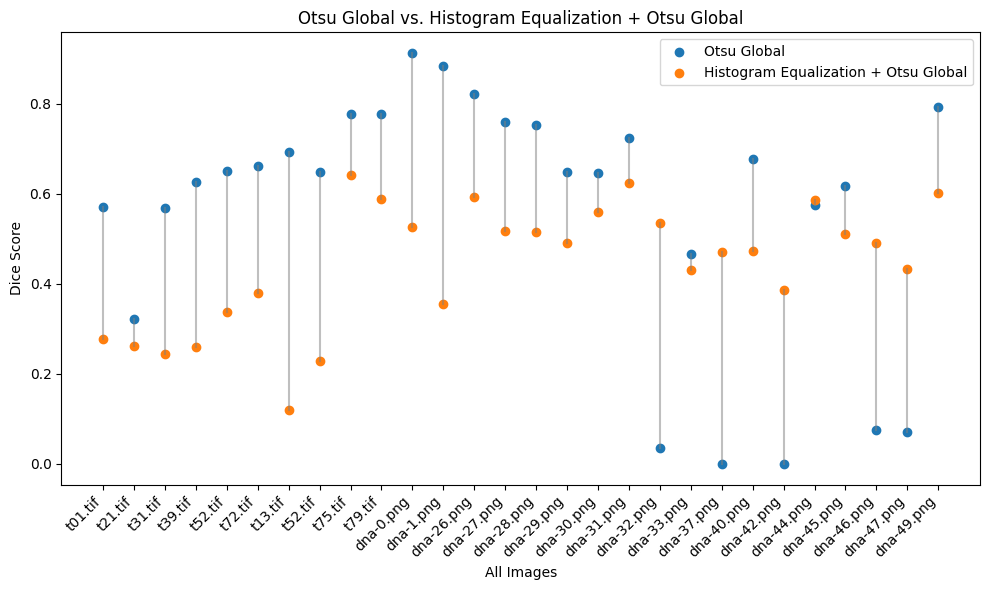

In [ ]:
# Generate indices for x-axis ticks corresponding to image labels
file_names = np.arange(len(labels))

# Create a spaghetti plot comparing Dice scores of global Otsu vs. histogram equalization + global Otsu
plot_pairwise_scores(
    file_names,
    dice_all_global,
    all_dice_scores_histeq_global,
    labels=labels,
    title="Otsu Global vs. Histogram Equalization + Otsu Global",
    xlabel="All Images",
    legend_labels=("Otsu Global", "Histogram Equalization + Otsu Global")
)

Although this can help certain images, the paired Dice score plot shows that, in many cases, histogram equalization degraded segmentation performance relative to pure Otsu thresholding. Especially on darker or noisier images, over-amplification of noise led to worse segmentations, with large drops in Dice scores for several images. Therefore, this method proved unsuitable for our datasets.

**Mean Filter + Otsu Global**

Mean filtering smooths the image by reducing high-frequency noise. We hypothesized it could help suppress background noise and improve thresholding robustness. 

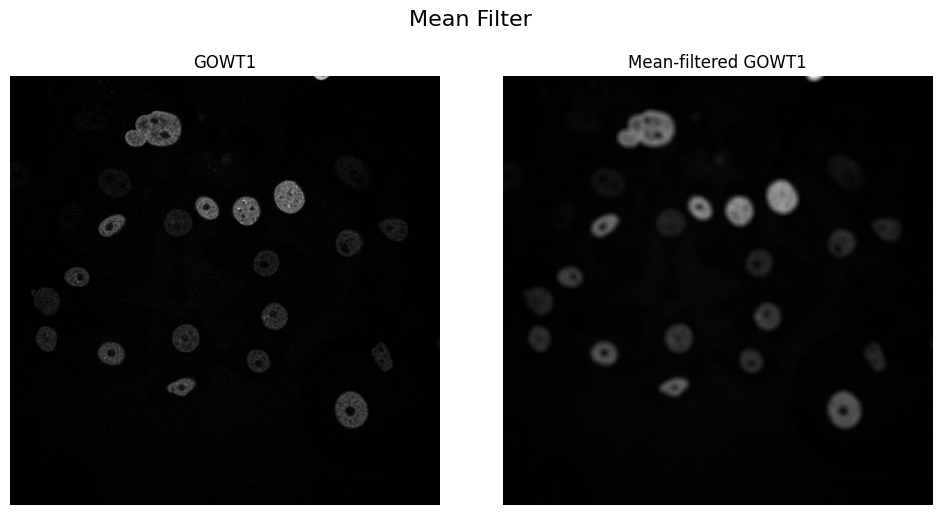

In [ ]:
# Apply mean filtering to the GOWT1 image to reduce noise by local averaging
from src.pre_processing import mean_filter

img_gowt1_filtered = mean_filter(img_gowt1)

# Display the original and mean-filtered GOWT1 images side by side
images_filtered = [img_gowt1, img_gowt1_filtered]
titles_img_histeq = ["GOWT1", "Mean-filtered GOWT1"]

plot_images_fixed_size(images_filtered, titles=titles_img_histeq, main_title="Mean Filter")

In [ ]:

# Import function to apply mean filtering followed by global Otsu thresholding and compute Dice scores
from src.Dice_Score_comparison import calculate_dice_scores_meanfilter_global

# Apply mean filter + global Otsu thresholding on all images and calculate Dice scores for each dataset
dice_scores_NIH3T3_meanfilter_global = calculate_dice_scores_meanfilter_global(imgs_NIH3T3, gts_NIH3T3)
dice_scores_N2DL_HeLa_meanfilter_global = calculate_dice_scores_meanfilter_global(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_scores_N2DH_GOWT1_meanfilter_global = calculate_dice_scores_meanfilter_global(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)

# Combine Dice scores from all datasets into a single vector for comparison and evaluation
all_dice_scores_meanfilter_global = (dice_scores_N2DH_GOWT1_meanfilter_global + dice_scores_N2DL_HeLa_meanfilter_global + dice_scores_NIH3T3_meanfilter_global)

KeyboardInterrupt: 

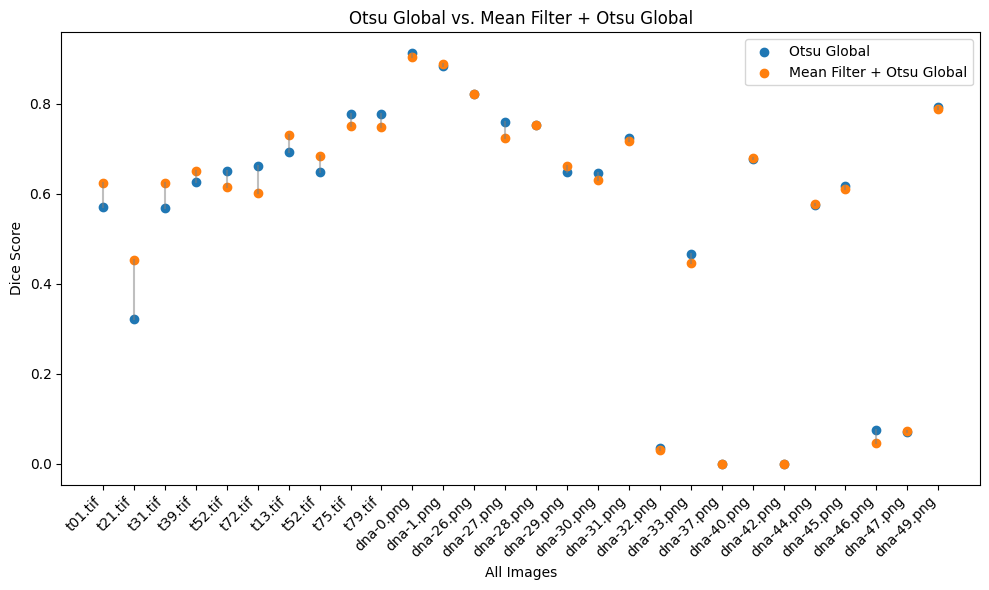

In [ ]:
# Create a spaghetti plot comparing Dice scores of global Otsu vs. mean filter + global Otsu
plot_pairwise_scores(
    file_names,
    dice_all_global,
    all_dice_scores_meanfilter_global,
    labels=labels,
    title="Otsu Global vs. Mean Filter + Otsu Global",
    xlabel="All Images",
    legend_labels=("Otsu Global", "Mean Filter + Otsu Global")
)

The paired Dice plot reveals that mean filtering had minimal impact overall: Dice scores stayed nearly identical to pure Otsu results, with minor fluctuations. Thus, mean filtering alone neither significantly improved nor deteriorated segmentation quality, but its simplicity make it a reasonable candidate to combine with other methods.

**Wiener Filter + Otsu Global**

Wiener filtering attempts to estimate and remove background by modeling local noise statistics.

In [ ]:
# Apply local Wiener filtering to estimate the background of the GOWT1 image
from src.pre_processing import local_wiener_filter

background = local_wiener_filter(img_gowt1)
img_gowt1_wiener = img_gowt1 - background  # Remove estimated background to enhance foreground structures

# Display the original and background-corrected images side by side
images_wiener = [img_gowt1, img_gowt1_wiener]
titles_img_wiener = ["GOWT1", "GOWT1 with Wiener-based Background Removal"]

plot_images_fixed_size(images_wiener, titles=titles_img_wiener, main_title="Wiener Filter-based Background Removal")

KeyboardInterrupt: 

In [ ]:
# Note: This process is computationally intensive and may take significant time to complete.

# Import function to apply Wiener filtering followed by global Otsu thresholding and calculate Dice scores
from src.Dice_Score_comparison import calculate_dice_scores_wienerfilter_global

# Apply Wiener filter + global Otsu thresholding on all images and compute Dice scores per dataset
dice_scores_NIH3T3_wienerfilter_global = calculate_dice_scores_wienerfilter_global(imgs_NIH3T3, gts_NIH3T3)
dice_scores_N2DL_HeLa_wienerfilter_global = calculate_dice_scores_wienerfilter_global(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_scores_N2DH_GOWT1_wienerfilter_global = calculate_dice_scores_wienerfilter_global(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)

# Combine Dice scores from all datasets into a single vector for comparative evaluation
all_dice_scores_wienerfilter_global = (
    dice_scores_N2DH_GOWT1_wienerfilter_global
    + dice_scores_N2DL_HeLa_wienerfilter_global
    + dice_scores_NIH3T3_wienerfilter_global
)

# Save the combined Dice scores to disk for reuse without recomputation
np.save(os.path.join(project_root, "output", "all_dice_scores_wienerfilter"), all_dice_scores_wienerfilter_global)

KeyboardInterrupt: 

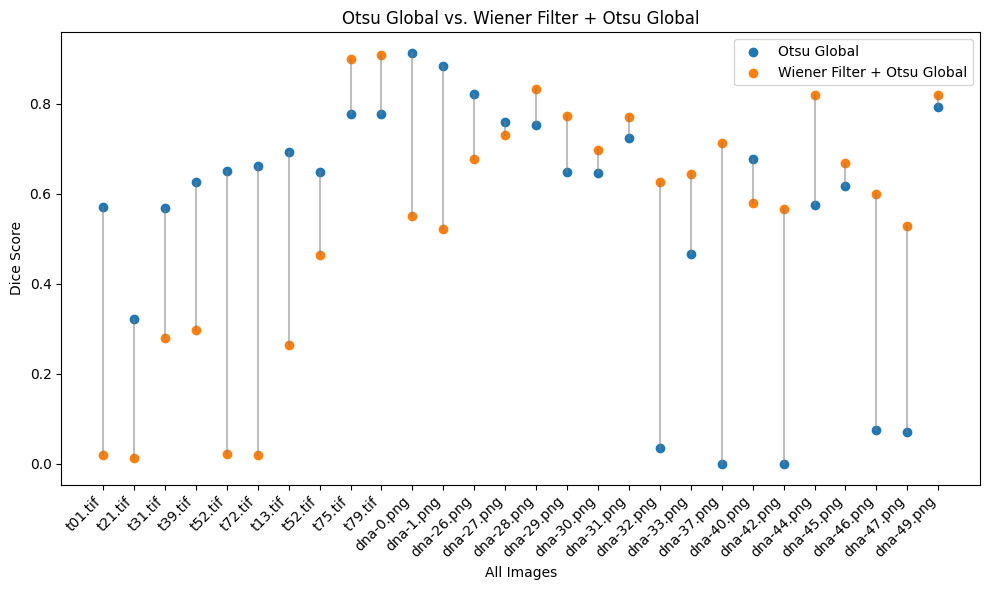

In [ ]:
# The Dice scores were previously calculated and saved (computation took approximately 40 minutes).

# Load the saved Dice scores for the Wiener filter + global Otsu thresholding approach
all_dice_scores_wienerfilter_global = np.load(os.path.join(project_root, "output", "all_dice_scores_wienerfilter.npy"))

# Generate a spaghetti plot comparing Dice scores of global Otsu vs. Wiener filter + global Otsu
plot_pairwise_scores(
    file_names,
    dice_all_global,
    all_dice_scores_wienerfilter_global,
    labels=labels,
    title="Otsu Global vs. Wiener Filter + Otsu Global",
    xlabel="All Images",
    legend_labels=("Otsu Global", "Wiener Filter + Otsu Global")
)

The paired Dice plot shows that Wiener filtering improved several images compared to Otsu alone but also caused major failures for some, where Dice scores dropped to near zero. These extreme outliers indicate instability and high sensitivity to parameter choices, making Wiener filtering unreliable as a general pre-processing step.

**Optimization of Gamma Parameter**

Given the promising results of gamma correction, we optimized the gamma parameter across all datasets by sweeping values from 0.1 to 2.0.

=== Processing N2DH-GOWT1 ===
Gamma 0.10 → Mean Dice: 0.2934
Gamma 0.20 → Mean Dice: 0.2934
Gamma 0.30 → Mean Dice: 0.2934
Gamma 0.40 → Mean Dice: 0.2934
Gamma 0.50 → Mean Dice: 0.4482
Gamma 0.60 → Mean Dice: 0.6783
Gamma 0.70 → Mean Dice: 0.6879
Gamma 0.80 → Mean Dice: 0.6401
Gamma 0.90 → Mean Dice: 0.5958
Gamma 1.00 → Mean Dice: 0.5471
Gamma 1.10 → Mean Dice: 0.4716
Gamma 1.20 → Mean Dice: 0.4440
Gamma 1.30 → Mean Dice: 0.3843
Gamma 1.40 → Mean Dice: 0.3571
Gamma 1.50 → Mean Dice: 0.3164
Gamma 1.60 → Mean Dice: 0.3009
Gamma 1.70 → Mean Dice: 0.2712
Gamma 1.80 → Mean Dice: 0.2441
Gamma 1.90 → Mean Dice: 0.2359
Gamma 2.00 → Mean Dice: 0.2152
=== Processing N2DL-HeLa ===
Gamma 0.10 → Mean Dice: 0.8865
Gamma 0.20 → Mean Dice: 0.8828
Gamma 0.30 → Mean Dice: 0.8753
Gamma 0.40 → Mean Dice: 0.8623
Gamma 0.50 → Mean Dice: 0.8453
Gamma 0.60 → Mean Dice: 0.8238
Gamma 0.70 → Mean Dice: 0.7966
Gamma 0.80 → Mean Dice: 0.7738
Gamma 0.90 → Mean Dice: 0.7441
Gamma 1.00 → Mean Dice: 0.7164
Gamma 1.10 

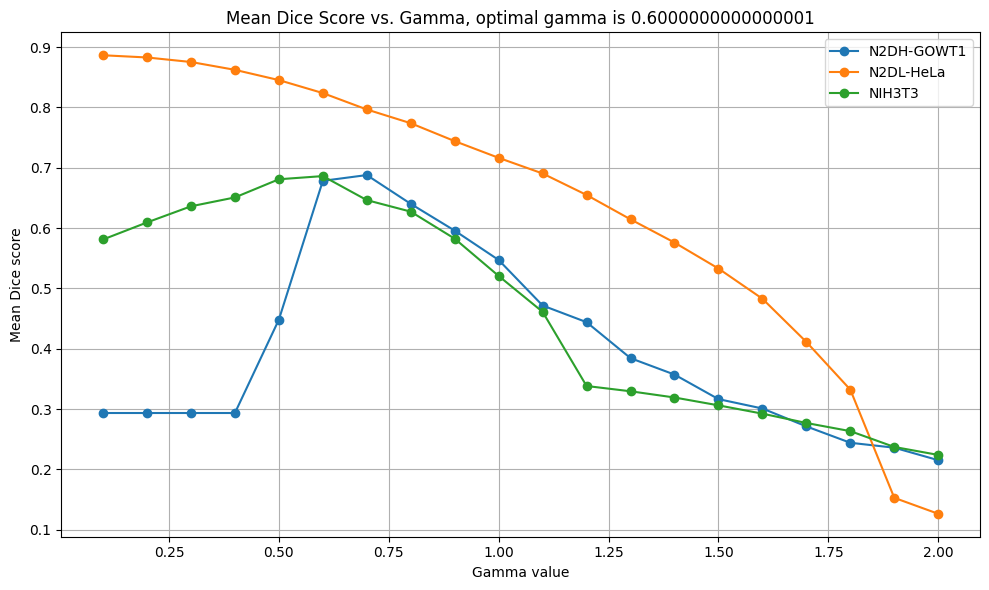

In [ ]:
# Import functions to perform gamma optimization and plotting across multiple datasets
from src.optimization_gamma import evaluate_datasets_gamma, find_best_gamma, plot_mean_dice_vs_gamma


# Define gamma values to test from 0.1 to 2.0 with 0.1 increments
gamma_values = np.arange(0.1, 2.1, 0.1)

# Define datasets with their respective image-loading functions
datasets = [
        ('N2DH-GOWT1', load_n2dh_gowt1_images),
        ('N2DL-HeLa', load_n2dl_hela_images),
        ('NIH3T3',  load_nih3t3_images),]

# Evaluate mean Dice scores for each gamma value across all datasets
all_means_gamma = evaluate_datasets_gamma(datasets, gamma_values, path=project_root)

# Identify the gamma value yielding the highest average Dice score
best_gamma, best_dice = find_best_gamma(all_means_gamma, gamma_values)
print(f"Optimal gamma value: {best_gamma:.2f}  Mean Dice = {best_dice:.4f}")

# Plot the mean Dice scores vs. gamma values for all datasets, highlighting the optimal gamma
dataset_names = [name for name, _ in datasets]
plot_mean_dice_vs_gamma(gamma_values, all_means_gamma, dataset_names, y=best_gamma)

The highest mean dice score across all datasets is achieved with gamma of 0.6, confirming our earlier empirical choice. Beyond gamma 0.6, Dice scores declined rapidly, especially for N2DL-HeLa, highlighting the importance of careful parameter tuning for consistent performance.

**Combining Gamma Correction with Mean Filtering**

Since mean filtering by itself was neutral but offered noise suppression benefits, we explored combining it with the optimal gamma correction before applying global Otsu. This combination was chosen because mean filtering can reduce background noise that may remain or is even enhanced after gamma correction, which makes it a logical next step. 

In [ ]:
# Import function to apply gamma correction followed by mean filtering and global Otsu thresholding, and compute Dice scores
from src.Dice_Score_comparison import calculate_dice_scores_gamma_meanfilter_global

# Apply gamma correction + mean filter + global Otsu thresholding on all images and compute Dice scores per dataset
dice_scores_NIH3T3_gamma_meanfilter_global = calculate_dice_scores_gamma_meanfilter_global(imgs_NIH3T3, gts_NIH3T3)
dice_scores_N2DL_HeLa_gamma_meanfilter_global = calculate_dice_scores_gamma_meanfilter_global(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_scores_N2DH_GOWT1_gamma_meanfilter_global = calculate_dice_scores_gamma_meanfilter_global(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)

# Combine Dice scores from all datasets into a single vector for comparative analysis
all_dice_scores_gamma_meanfilter_global = (dice_scores_N2DH_GOWT1_gamma_meanfilter_global + dice_scores_N2DL_HeLa_gamma_meanfilter_global + dice_scores_NIH3T3_gamma_meanfilter_global)

In [ ]:
# Import plotting functions for pairwise and triplet Dice score comparisons
from src.Plots import plot_pairwise_scores, plot_triplet_scores

# Define indices for x-axis labels (image order) in the plots
file_names = np.arange(len(labels))

# Plot pairwise comparison: Otsu Global vs. Gamma Correction + Mean Filter + Otsu Global
plot_pairwise_scores(
    file_names,
    dice_all_global,
    all_dice_scores_gamma_meanfilter_global,
    labels=labels,
    title="Otsu Global vs. Gamma Correction + Mean Filter + Otsu Global",
    xlabel="All Images",
    legend_labels=("Otsu Global", "Gamma Correction + Mean Filter + Otsu Global")
)

NameError: name 'np' is not defined

The paired Dice plot shows a clear trend: Gamma correction + mean filter + Otsu global outperforms Otsu global in most images, with the combination stabilizing Dice scores across all datasets.

**Final Comparative Analysis**

To compare the top approaches directly, we plotted Dice scores of three methods: Otsu global, gamma correction + Otsu global, and gamma correction + mean filter + Otsu global. The triplet plot clearly shows that gamma correction (with or without mean filtering) improves Dice scores for most images over pure Otsu global, with the combination of gamma and mean filter slightly better on average. However, the improvement of adding the mean filter over gamma alone is marginal.

From the final plots, we see that mean filtering does not provide significant benefits beyond gamma correction, and in some cases may even cause minor degradations. This suggests that adding mean filtering increases complexity without robust advantages. At least for global otsu thresholding.

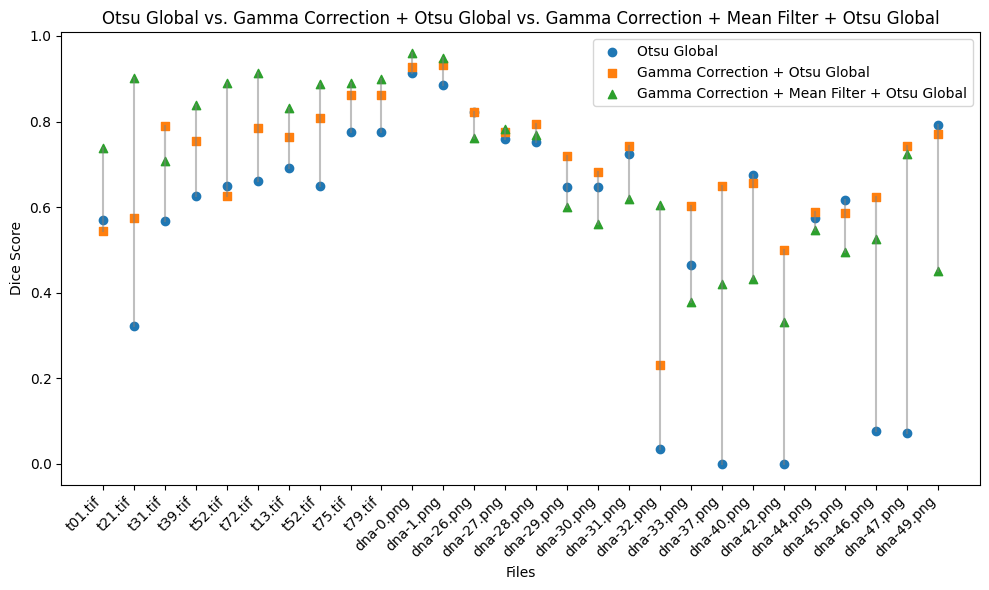

In [ ]:
# Plot triplet comparison: Otsu Global vs. Gamma Correction + Otsu Global vs. Gamma Correction + Mean Filter + Otsu Global
plot_triplet_scores(
    file_names,
    dice_all_global,
    all_dice_scores_gamma_global,
    all_dice_scores_gamma_meanfilter_global,
    labels=labels,
    legend_labels=(
        "Otsu Global",
        "Gamma Correction + Otsu Global",
        "Gamma Correction + Mean Filter + Otsu Global"
    ),
    title="Otsu Global vs. Gamma Correction + Otsu Global vs. Gamma Correction + Mean Filter + Otsu Global"
)

**Conclusion of Extended Analysis:**

Gamma correction with optimal gamma (0.6) consistently improved segmentation performance across datasets. While adding mean filtering offered slight further stabilization, the gain was not significant enough to justify the extra processing complexity. Therefore, we ultimately chose gamma correction alone for global otsu thresholding as the optimal pipeline due to its simplicity, consistent improvements, and minimal risk of extreme failures seen with methods like Wiener filtering.

## 7. Results & Visualization: Presenting outcomes using comparative plots

To evaluate our methods, we began by comparing our Otsu implementations with the widely-used `scikit-image` package. Our global Otsu replicated `threshold_otsu` by computing a histogram with normalization to [0,255] and rescaling the threshold back to the original intensity range, producing nearly identical results. Our local Otsu implementation performed pixel-wise local thresholding with exact reflection padding, while the package’s `rank.otsu` uses fast C-optimized routines on uint8 data and a disk-shaped window. Minor differences were expected because `rank.otsu` discretizes intensity bins early, introducing small quantization effects, especially near edges. This explains occasional deviations visible in our first scatter plots, which nevertheless showed that our thresholds tracked the package’s behavior very closely.


In [ ]:
# Import functions for calculating Dice scores using the scikit-image package implementations
from src.Dice_Score_comparison import (calculate_dice_scores_otsu_package, calculate_dice_scores_local_package, calculate_package_dice_scores)

# Compute Dice scores for each dataset using the package's Otsu Global implementation
dice_all_gowt1_otsu_package = calculate_dice_scores_otsu_package(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
dice_all_hela_otsu_package = calculate_dice_scores_otsu_package(imgs_N2DL_HeLa, gts_N2DL_HeLa)
dice_all_nih_otsu_package = calculate_dice_scores_otsu_package(imgs_NIH3T3, gts_NIH3T3)

# Compute Dice scores for each dataset using the package's Otsu Local implementation (radius=15)
dice_all_gowt1_local_package = calculate_dice_scores_local_package(imgs_N2DH_GOWT1, gts_N2DH_GOWT1, radius=15)
dice_all_hela_local_package = calculate_dice_scores_local_package(imgs_N2DL_HeLa, gts_N2DL_HeLa, radius=15)
dice_all_nih_local_package = calculate_dice_scores_local_package(imgs_NIH3T3, gts_NIH3T3, radius=15)

# Compute Dice scores for our own Otsu Global implementation evaluated with the package metric
package_dice_all_gowt1_global = calculate_package_dice_scores(imgs_N2DH_GOWT1, gts_N2DH_GOWT1)
package_dice_all_hela_global = calculate_package_dice_scores(imgs_N2DL_HeLa, gts_N2DL_HeLa)
package_dice_all_nih_global = calculate_package_dice_scores(imgs_NIH3T3, gts_NIH3T3)

# Create combined vectors of Dice scores for all images across datasets

# Combined Dice scores using package Otsu Global
dice_all_otsu_package = (
    dice_all_gowt1_otsu_package + dice_all_hela_otsu_package + dice_all_nih_otsu_package
)

# Combined Dice scores using package Otsu Local (radius=15)
dice_all_local_package = (
    dice_all_gowt1_local_package + dice_all_hela_local_package + dice_all_nih_local_package
)

# Combined Dice scores using our Otsu Global evaluated with package's metric
package_dice_all_global = (
    package_dice_all_gowt1_global + package_dice_all_hela_global + package_dice_all_nih_global
)

# Combined Dice scores using our own Otsu Global implementation (float values)
dice_all_global = dice_all_gowt1_global + dice_all_hela_global + dice_all_nih_global

# Combined Dice scores using our own Otsu Local implementation (radius=15)
dice_all_local = dice_all_gowt1_local + dice_all_hela_local + dice_all_nih_local


NameError: name 'dice_all_gowt1_global' is not defined

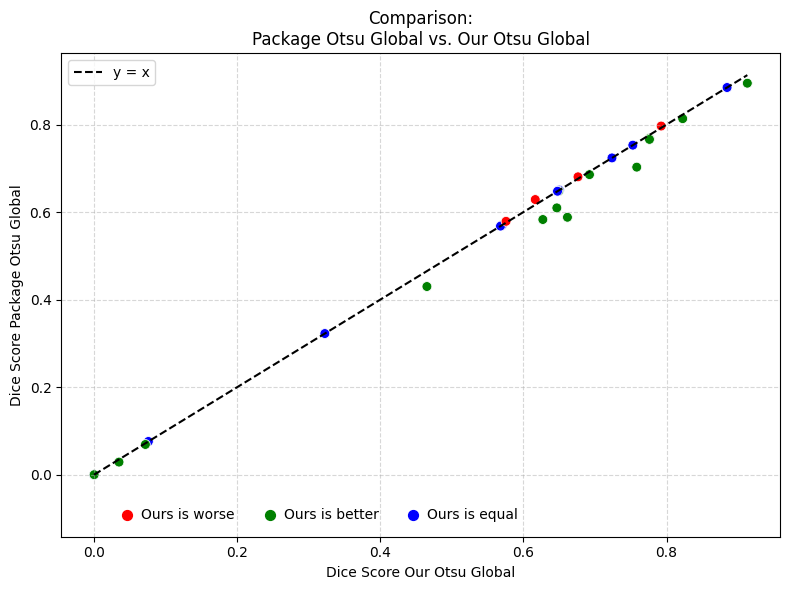

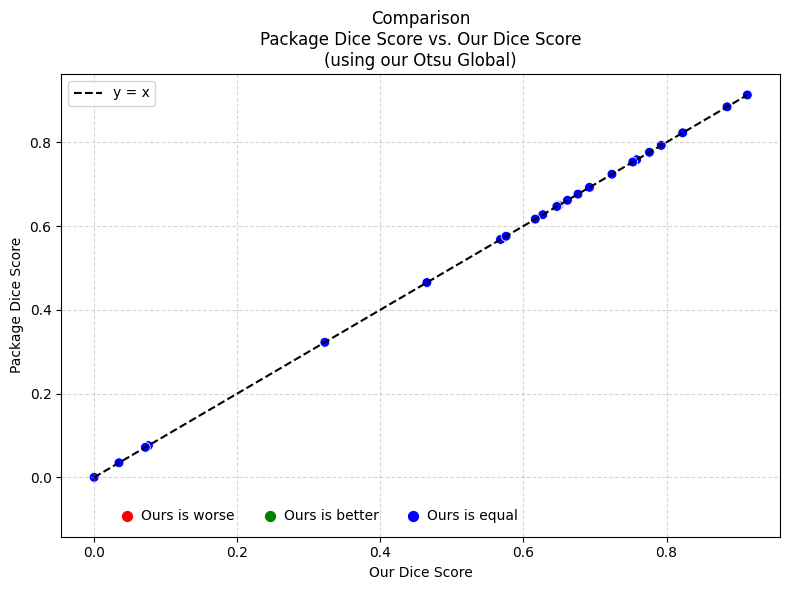

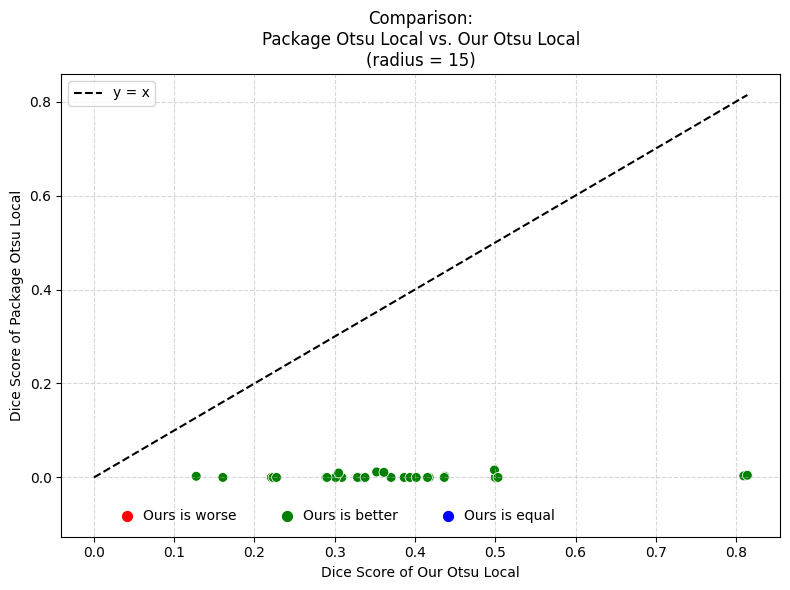

In [ ]:
# Scatterplot comparing our Otsu Global Dice scores with the package's Otsu Global scores
scatterplot_without_regression(
    dice_all_global,
    dice_all_otsu_package,
    xlabel="Dice Score Our Otsu Global",
    ylabel="Dice Score Package Otsu Global",
    title="Comparison:\nPackage Otsu Global vs. Our Otsu Global",
    label_red="Ours is worse",
    label_green="Ours is better",
    label_blue="Ours is equal"
)

# Scatterplot comparing our computed Dice scores with the package's Dice scores 
# for our own Otsu Global segmentations (evaluated using package's metric)
scatterplot_without_regression(
    dice_all_global,
    package_dice_all_global,
    xlabel="Our Dice Score",
    ylabel="Package Dice Score",
    title="Comparison\nPackage Dice Score vs. Our Dice Score\n(using our Otsu Global)",
    label_red="Ours is worse",
    label_green="Ours is better",
    label_blue="Ours is equal"
)

# Scatterplot comparing our Otsu Local Dice scores with the package's Otsu Local Dice scores (radius=15)
scatterplot_without_regression(
    dice_all_local,
    dice_all_local_package,
    xlabel="Dice Score of Our Otsu Local",
    ylabel="Dice Score of Package Otsu Local",
    title="Comparison:\nPackage Otsu Local vs. Our Otsu Local\n(radius = 15)",
    label_red="Ours is worse",
    label_green="Ours is better",
    label_blue="Ours is equal"
)

The first comparative plots confirmed this: almost all points lie on or very close to the y=x line for both the global and local Otsu implementations. These plots validated our implementation as equivalent to skimage within reasonable floating-point error. Our Dice score implementation even produces results identical to those obtained using the `binary.dc` function from the `medpy.metric` package.

**calculation of the best otsu local**

Knowing that local Otsu thresholding can outperform global Otsu if the window radius is well chosen, we systematically explored radii per image across datasets. However, this exhaustive radius search was computationally expensive; some images took hours. To keep analysis reproducible and efficient, we saved the optimal radii per image for later steps. So only run the code cell after the radii function for time efficiency. 

Anyways this exploration revealed clear trends: 
Images in GOWT1, with large and sparse nuclei, required larger radii to capture context, while NIH3T3, with small and dense nuclei, needed smaller radii for accurate thresholding. The HeLa dataset fell in between, with optimal radii reflecting moderate cell size and density.

In [ ]:
from src.radius_calculation import calculate_best_radii_and_dice1, print_clean_results

# Define the range of radii to evaluate (e.g., 10 and 20)
radii = list(range(0, 1500, 50))

# Compute the best radius and corresponding Dice score for each image in the GOWT1 dataset
results_gowt1_best_local_radius, results_gowt1_best_local_dice = calculate_best_radii_and_dice1(
    imgs_N2DH_GOWT1, gts_N2DH_GOWT1, radii
)

# Compute the best radius and Dice scores for each image in the HeLa dataset
results_hela_best_local_radius, results_hela_best_local_dice = calculate_best_radii_and_dice1(
    imgs_N2DL_HeLa, gts_N2DL_HeLa, radii
)

# Compute the best radius and Dice scores for each image in the NIH3T3 dataset
results_nih_best_local_radius, results_nih_best_local_dice = calculate_best_radii_and_dice1(
    imgs_NIH3T3, gts_NIH3T3, radii
)

# Combine all best radii into a single list for summary
results_best_local_radius = (
    results_gowt1_best_local_radius + results_hela_best_local_radius + results_nih_best_local_radius
)
print("Radius_with_best_Dice Score =", results_best_local_radius)

# Bundle the results for structured reporting
all_results = [
    (results_gowt1_best_local_radius, results_gowt1_best_local_dice),
    (results_hela_best_local_radius, results_hela_best_local_dice),
    (results_nih_best_local_radius, results_nih_best_local_dice)
]

# Create a dictionary of cleaned results: maps dataset → (image, best radius, Dice score)
cleanresult = print_clean_results(all_results, all_image_paths)

# Print the cleaned results per dataset, formatted for readability
for ds, items in cleanresult.items():
    print(f"\n=== Dataset: {ds} ===")
    for name, r, s in items:
        print(f"  {name:20s} → best radius = {r:3d}, Dice = {s:.4f}")

Processing images:   0%|          | 0/6 [00:17<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# For time efficiency, we directly assign precomputed optimal radii instead of recalculating them.
# These values correspond to the best-performing radii per image in each dataset.

# Optimal radii (best Dice) for GOWT1 dataset images
results_gowt1_best_local_radius = [350.0, 550.0, 450.0, 450.0, 900.0, 100.0]

# Optimal radii (best Dice) for HeLa dataset images
results_hela_best_local_radius = [700.0, 200.0, 50.0, 50.0]

# Optimal radii (best Dice) for NIH3T3 dataset images
results_nih_best_local_radius = [550.0, 500.0, 150.0, 100.0, 250.0, 150.0, 100.0, 100.0, 100.0, 150.0, 100.0, 200.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0]

# Combine results from all datasets into a single list for unified analysis or visualization
results_best_local_radius = (results_gowt1_best_local_radius + results_hela_best_local_radius + results_nih_best_local_radius)

# Print the combined list of optimal radii for transparency and reproducibility
print("Radius_with_best_Dice Score =", results_best_local_radius)

Radius_with_best_Dice Score = [350.0, 550.0, 450.0, 450.0, 900.0, 100.0, 700.0, 200.0, 50.0, 50.0, 550.0, 500.0, 150.0, 100.0, 250.0, 150.0, 100.0, 100.0, 100.0, 150.0, 100.0, 200.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0]


Mean radius GOWT1 = 467
Median radius GOWT1 = 450

Mean radius HeLa = 250
Median radius HeLa = 125

Mean radius NIH3T3 = 184
Median radius NIH3T3 = 150


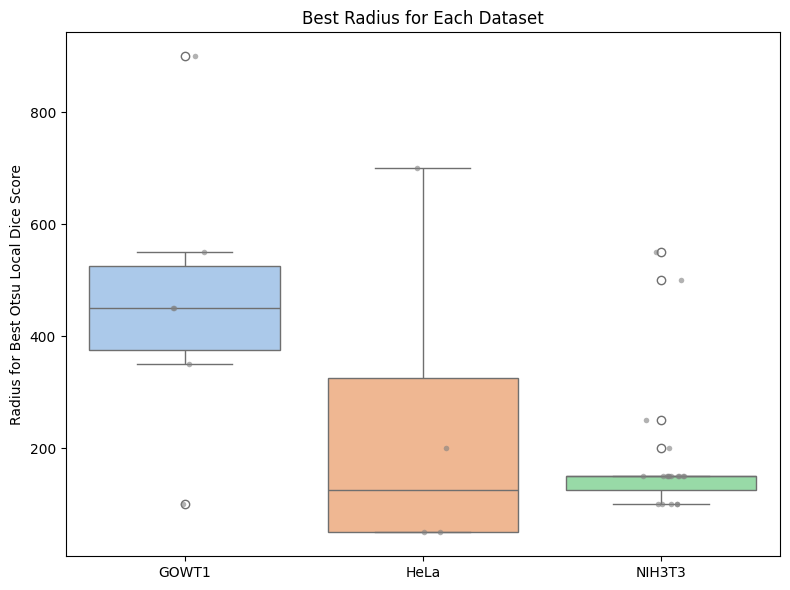

In [ ]:
from src.Plots import plot_single_grouped_boxplot, combine_results_to_dataframe

# --- Compute and print basic statistics on the optimal radii for each dataset ---

GOWT1_radius = np.array(results_gowt1_best_local_radius)
print("Mean radius GOWT1 =", f"{np.mean(GOWT1_radius):.0f}")
print("Median radius GOWT1 =", f"{np.median(GOWT1_radius):.0f}")
print()  # line break between outputs for clarity

HeLa_radius = np.array(results_hela_best_local_radius)
print("Mean radius HeLa =", f"{np.mean(HeLa_radius):.0f}")
print("Median radius HeLa =", f"{np.median(HeLa_radius):.0f}")
print()

NIH3T3_radius = np.array(results_nih_best_local_radius)
print("Mean radius NIH3T3 =", f"{np.mean(NIH3T3_radius):.0f}")
print("Median radius NIH3T3 =", f"{np.median(NIH3T3_radius):.0f}")

# --- Combine radius results into a single DataFrame for visualization ---

df_all = combine_results_to_dataframe(
    names=["GOWT1", "HeLa", "NIH3T3"],
    lists=[results_gowt1_best_local_radius, results_hela_best_local_radius, results_nih_best_local_radius]
)

# --- Plot a grouped boxplot comparing the distribution of optimal radii across datasets ---

plot_single_grouped_boxplot(
    df=df_all,
    title="Best Radius for Each Dataset",
    ylabel="Radius for Best Otsu Local Dice Score"
)

The boxplots of optimal radii distributions revealed a clear pattern: GOWT1 favored the large radii (median ~450), while NIH3T3 (median ~150), and HeLa intermediate values (median ~125). These distributions showed wide spreads, but medians were less sensitive to outlier images than means. This is crucial: since extreme optimal radii can arise from atypical images (e.g., overexposed fields), medians provide a robust choice when generalizing to new datasets of similar biological properties. Our decision to proceed with medians was supported both statistically and by the plotted distributions, which confirmed that medians represent the central tendency better than means in skewed distributions.

**Otsu global vs. Otsu local (median radius)**

Using these median optimal radii, we applied local Otsu thresholding across all datasets and found a mean Dice score improvement of +27.20% compared to global Otsu.

In [ ]:
# Compute Dice scores for each dataset using package Otsu Local with the median optimal radius determined per dataset

median_dice_all_gowt1_local_package_optimal = calculate_dice_scores_local_package(imgs_N2DH_GOWT1, gts_N2DH_GOWT1, radius=450)
median_dice_all_hela_local_package_optimal = calculate_dice_scores_local_package(imgs_N2DL_HeLa, gts_N2DL_HeLa, radius=125)
median_dice_all_nih_local_package_optimal = calculate_dice_scores_local_package(imgs_NIH3T3, gts_NIH3T3, radius=150)

# Concatenate the Dice scores of all datasets into a single list for further analysis
median_dice_all_local_package_optimal = (median_dice_all_gowt1_local_package_optimal + median_dice_all_hela_local_package_optimal + median_dice_all_nih_local_package_optimal)

Increase of Dice score of GOWT1 = 0.77%
Increase of Dice score of HeLa = -21.07%
Increase of Dice score of NIH3T3 = 8.67%


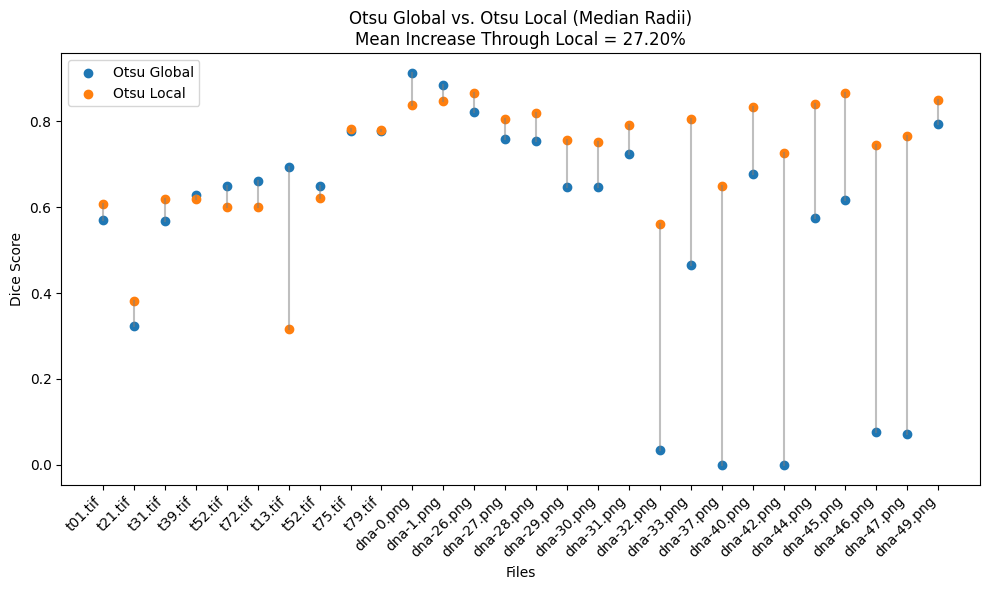

NameError: name 'scatterplot_without_regression' is not defined

In [ ]:
# Compute the percentage improvement of median-optimized local Otsu over global Otsu by comparing their mean Dice scores
median_increase_global_local = ((np.mean(np.array(median_dice_all_local_package_optimal)) - np.mean(np.array(dice_all_global))) / np.mean(np.array(dice_all_global)))

# Compute and print the percentage improvement of median-optimized local Otsu over global Otsu by comparing their mean Dice scores for each Dataset
median_increase_gowt1_global_local = (np.mean(np.array(median_dice_all_gowt1_local_package_optimal))-np.mean(np.array(dice_all_gowt1_global)))/np.mean(np.array(dice_all_gowt1_global))
median_increase_hela_global_local = (np.mean(np.array(median_dice_all_gowt1_local_package_optimal))-np.mean(np.array(dice_all_hela_global)))/np.mean(np.array(dice_all_hela_global))
median_increase_nih_global_local = (np.mean(np.array(median_dice_all_gowt1_local_package_optimal))-np.mean(np.array(dice_all_nih_global)))/np.mean(np.array(dice_all_nih_global))

print("Increase of Dice score of GOWT1 =", f"{median_increase_gowt1_global_local * 100:.2f}%")
print("Increase of Dice score of HeLa =", f"{median_increase_hela_global_local * 100:.2f}%")
print("Increase of Dice score of NIH3T3 =", f"{median_increase_nih_global_local * 100:.2f}%")

# Generate a spaghetti plot comparing Dice scores of global Otsu and median-radius local Otsu
plot_pairwise_scores(
    file_names,
    dice_all_global,
    median_dice_all_local_package_optimal,
    labels=labels,
    title=(f"Otsu Global vs. Otsu Local (Median Radii)\n"f"Mean Increase Through Local = {median_increase_global_local * 100:.2f}%"),
    legend_labels=("Otsu Global", "Otsu Local")
)

# Create a scatterplot comparing local vs. global Dice scores to highlight improvements or degradations
scatterplot_without_regression(
    median_dice_all_local_package_optimal,
    dice_all_global,
    xlabel="Dice Score of Local",
    ylabel="Dice Score of Global",
    title=(f"Otsu Global vs. Otsu Local (Median Radii)\n"f"Mean Increase Through Local = {median_increase_global_local * 100:.2f}%"),
    label_red="Local is worse",
    label_green="Local is better",
    label_blue="Local is equal"
)

These plots illustrate that local Otsu thresholding generally yields better segmentation results. This effect is particularly pronounced in the NIH3T3 images (dna-0.png to dna-49.png), where uneven illumination causes global Otsu to perform poorly, while the local method adapts to varying brightness and significantly improves the Dice score. In the N2DL-HeLa dataset (t13.tif to t79.tif), segmentation quality is mostly stable, although the median window size used for t13 appears suboptimal. For N2DH-GOWT1 (t01.tif to t72.tif), results show slight improvements as well as minor drops in performance.

**Otsu global vs. Otsu local (mean radius)**

When we repeated the same analysis using mean optimal radii, the mean Dice improvement dropped slightly to +2.82%. 

In [ ]:
# Compute Dice scores for each dataset using package Otsu Local thresholding with the dataset-specific *mean radius* 
# (determined previously) to evaluate if using the average window size improves segmentation accuracy.
mean_dice_all_gowt1_local_package_optimal = calculate_dice_scores_local_package(imgs_N2DH_GOWT1, gts_N2DH_GOWT1, radius=467)
mean_dice_all_hela_local_package_optimal = calculate_dice_scores_local_package(imgs_N2DL_HeLa, gts_N2DL_HeLa, radius=250)
mean_dice_all_nih_local_package_optimal = calculate_dice_scores_local_package(imgs_NIH3T3, gts_NIH3T3, radius=184)

# Combine Dice scores from all datasets into a single vector for comprehensive analysis
mean_dice_all_local_package_optimal = (mean_dice_all_gowt1_local_package_optimal + mean_dice_all_hela_local_package_optimal + mean_dice_all_nih_local_package_optimal)

Increase of Dice score of GOWT1 = 0.52%
Increase of Dice score of HeLa = -21.26%
Increase of Dice score of NIH3T3 = 8.40%


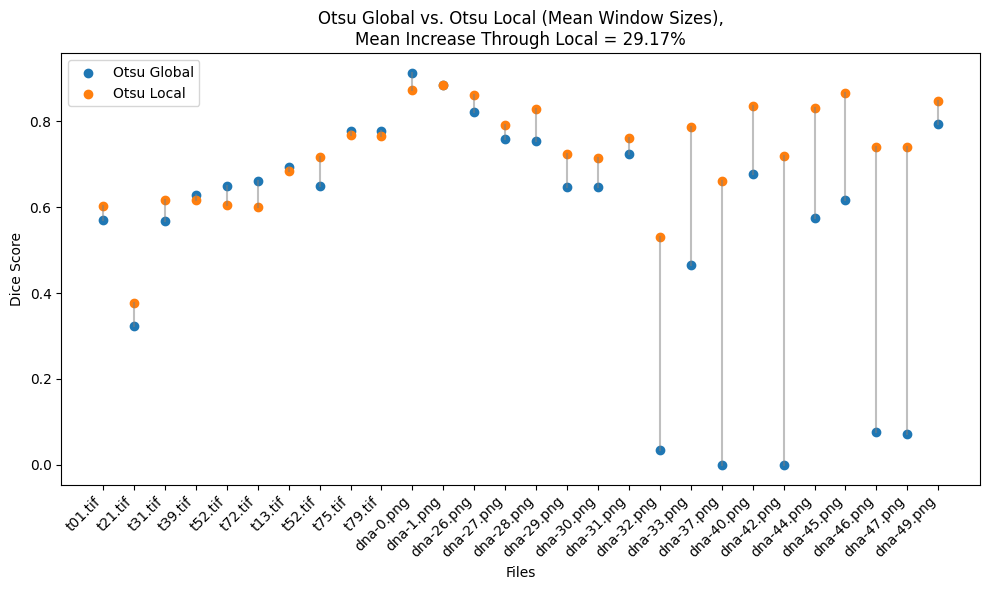

In [ ]:
# Compute the mean percentage improvement of Dice scores when using package Otsu Local (mean window sizes)
# relative to global Otsu thresholding; reports the average performance gain across all datasets.
mean_increase_global_local = ((np.mean(np.array(mean_dice_all_local_package_optimal)) - np.mean(np.array(dice_all_global))) / np.mean(np.array(dice_all_global)))

# Compute and print the mean percentage improvement of Dice scores when using package Otsu Local (mean window sizes) for each dataset
mean_increase_gowt1_global_local = (np.mean(np.array(mean_dice_all_gowt1_local_package_optimal))-np.mean(np.array(dice_all_gowt1_global)))/np.mean(np.array(dice_all_gowt1_global))
mean_increase_hela_global_local = (np.mean(np.array(mean_dice_all_gowt1_local_package_optimal))-np.mean(np.array(dice_all_hela_global)))/np.mean(np.array(dice_all_hela_global))
mean_increase_nih_global_local = (np.mean(np.array(mean_dice_all_gowt1_local_package_optimal))-np.mean(np.array(dice_all_nih_global)))/np.mean(np.array(dice_all_nih_global))

print("Increase of Dice score of GOWT1 =", f"{mean_increase_gowt1_global_local * 100:.2f}%")
print("Increase of Dice score of HeLa =", f"{mean_increase_hela_global_local * 100:.2f}%")
print("Increase of Dice score of NIH3T3 =", f"{mean_increase_nih_global_local * 100:.2f}%")

# Generate a spaghetti plot to visualize per-image Dice scores for Otsu global vs. Otsu local with mean window sizes,
# illustrating individual performance differences and overall trends.
plot_pairwise_scores(
    file_names,
    dice_all_global,
    mean_dice_all_local_package_optimal,
    labels=labels,
    title=f"Otsu Global vs. Otsu Local (Mean Window Sizes),\nMean Increase Through Local = {mean_increase_global_local * 100:.2f}%",
    legend_labels=("Otsu Global", "Otsu Local"),
)

The plots showed increased scatter and more outlier images performing worse than global Otsu, confirming that the mean was more susceptible to the influence of extreme optimal radius values, and underscoring why the median is preferable for practical application. Therefore we use the median radii for our final results.

**Otsu local vs gamma corrected Otsu local**

After establishing the optimal radii, we incorporated our best pre-processing step: gamma correction. Applying gamma correction prior to local Otsu thresholding (using the median radius per dataset) resulted in a slight improvement: the mean Dice score increased by +5.29% compared to local Otsu alone. This indicated that gamma correction enhanced contrast in challenging regions, enabling the local thresholding to delineate nuclei more accurately. Especially GOWT1 got improved masively with an incerase of Dice scores of 13.17%. The plots clearly showed almost universal gains across images, with very few images experiencing a performance drop.

In [ ]:
# Import function for applying gamma correction followed by local Otsu thresholding and calculating Dice scores.
from src.Dice_Score_comparison import calculate_dice_scores_gamma_local_package

# Compute Dice scores for each dataset after applying gamma correction (gamma=0.6) 
# and local Otsu thresholding with dataset-specific optimal radii determined previously.
dice_scores_N2DH_GOWT1_gamma_local = calculate_dice_scores_gamma_local_package(imgs_N2DH_GOWT1, gts_N2DH_GOWT1, radius=450)
dice_scores_N2DL_HeLa_gamma_local  = calculate_dice_scores_gamma_local_package(imgs_N2DL_HeLa, gts_N2DL_HeLa, radius=125)
dice_scores_NIH3T3_gamma_local     = calculate_dice_scores_gamma_local_package(imgs_NIH3T3, gts_NIH3T3, radius=150)

# Concatenate the Dice scores from all datasets into a single list for further analysis and comparison.
all_dice_scores_gamma_local = (dice_scores_N2DH_GOWT1_gamma_local + dice_scores_N2DL_HeLa_gamma_local + dice_scores_NIH3T3_gamma_local)

Increase of Dice score of GOWT1 = 13.17%
Increase of Dice score of HeLa = 10.29%
Increase of Dice score of NIH3T3 = 2.50%


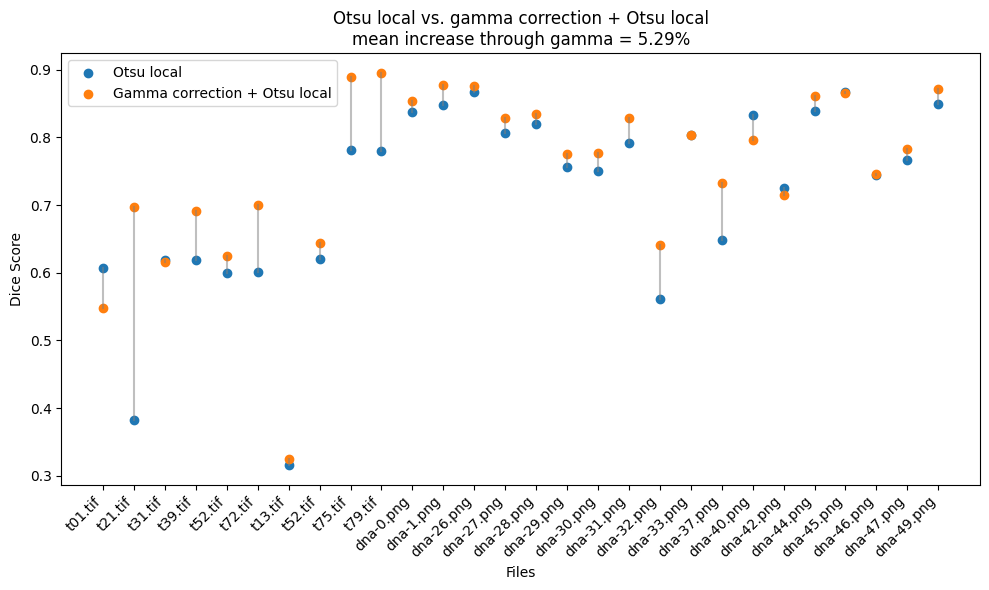

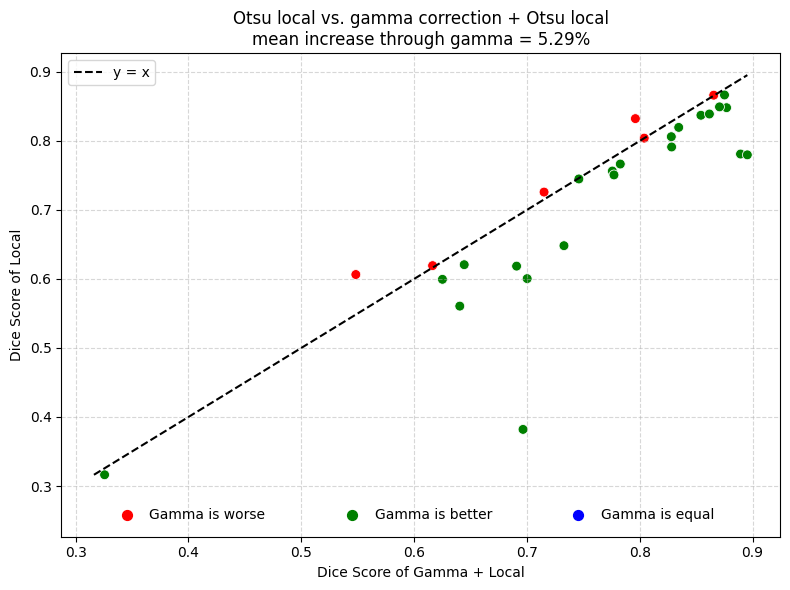

In [ ]:
# Calculate the relative mean Dice score improvement of gamma correction + local Otsu over plain local Otsu (with median window sizes).
median_increase_local_gamma_local = ((np.mean(np.array(all_dice_scores_gamma_local)) - np.mean(np.array(median_dice_all_local_package_optimal))) / np.mean(np.array(median_dice_all_local_package_optimal)))

# Calculate and print the relative mean Dice score improvement of gamma correction + local Otsu over plain local Otsu (with median window sizes) for each dataset.
median_increase_gowt1_local_gamma_local = (np.mean(np.array(dice_scores_N2DH_GOWT1_gamma_local))-np.mean(np.array(median_dice_all_gowt1_local_package_optimal)))/np.mean(np.array(median_dice_all_gowt1_local_package_optimal))
median_increase_hela_local_gamma_local = (np.mean(np.array(dice_scores_N2DL_HeLa_gamma_local))-np.mean(np.array(median_dice_all_hela_local_package_optimal)))/np.mean(np.array(median_dice_all_hela_local_package_optimal))
median_increase_nih_local_gamma_local = (np.mean(np.array(dice_scores_NIH3T3_gamma_local ))-np.mean(np.array(median_dice_all_nih_local_package_optimal)))/np.mean(np.array(median_dice_all_nih_local_package_optimal))

print("Increase of Dice score of GOWT1 =", f"{median_increase_gowt1_local_gamma_local * 100:.2f}%")
print("Increase of Dice score of HeLa =", f"{median_increase_hela_local_gamma_local * 100:.2f}%")
print("Increase of Dice score of NIH3T3 =", f"{median_increase_nih_local_gamma_local * 100:.2f}%")


# Plot pairwise comparison of Dice scores for each image: local Otsu vs. gamma correction + local Otsu,
# showing how gamma correction affects segmentation performance across datasets.
plot_pairwise_scores(
    file_names,
    median_dice_all_local_package_optimal,
    all_dice_scores_gamma_local,
    labels=labels,
    title=(f"Otsu local vs. gamma correction + Otsu local\n"f"mean increase through gamma = {median_increase_local_gamma_local * 100:.2f}%"),
    legend_labels=("Otsu local", "Gamma correction + Otsu local")
    )

# Scatterplot for direct point-by-point comparison of Dice scores with and without gamma correction,
# highlighting which images improve, degrade, or stay the same with gamma correction.
scatterplot_without_regression(
    all_dice_scores_gamma_local,
    median_dice_all_local_package_optimal,
    xlabel="Dice Score of Gamma + Local",
    ylabel="Dice Score of Local",
    title=(f"Otsu local vs. gamma correction + Otsu local\n"f"mean increase through gamma = {median_increase_local_gamma_local * 100:.2f}%"),
    label_red="Gamma is worse",
    label_green="Gamma is better",
    label_blue="Gamma is equal"
)

**Otsu global vs Otsu local**

Next, we directly compared our gamma-enhanced local Otsu with global Otsu thresholding to quantify the total improvement: we observed a striking mean Dice score increase of +33.93%. The scatterplot highlighted a strong trend of points below the y=x line, affirming that combining pre-processing (gamma correction) with local thresholding leads to far superior segmentation quality.

Increase of Dice score of GOWT1 = 14.87%
Increase of Dice score of HeLa = 22.42%
Increase of Dice score of NIH3T3 = 42.84%


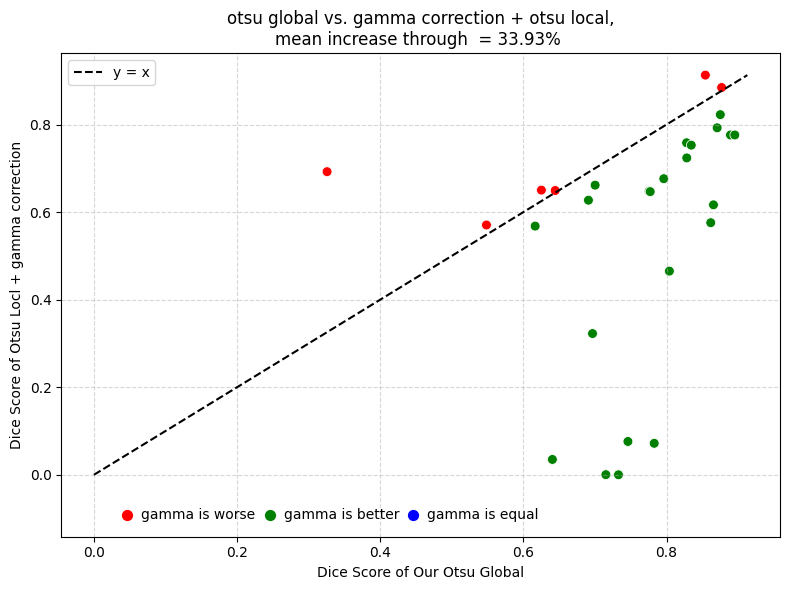

In [ ]:
# Calculate the relative mean improvement in Dice score when using gamma correction combined with local Otsu thresholding, compared to global Otsu.
median_increase_global_gamma_local = (np.mean(np.array(all_dice_scores_gamma_local))-np.mean(np.array(dice_all_global)))/np.mean(np.array(dice_all_global))

# Calculate and print improvements separately for each dataset
median_increase_gowt1_global_gamma_local = (np.mean(np.array(dice_scores_N2DH_GOWT1_gamma_local))-np.mean(np.array(dice_all_global)))/np.mean(np.array(dice_all_global))
median_increase_hela_global_gamma_local = (np.mean(np.array(dice_scores_N2DL_HeLa_gamma_local))-np.mean(np.array(dice_all_global)))/np.mean(np.array(dice_all_global))
median_increase_nih_global_gamma_local = (np.mean(np.array(dice_scores_NIH3T3_gamma_local ))-np.mean(np.array(dice_all_global)))/np.mean(np.array(dice_all_global))

print("Increase of Dice score of GOWT1 =", f"{median_increase_gowt1_global_gamma_local * 100:.2f}%")
print("Increase of Dice score of HeLa =", f"{median_increase_hela_global_gamma_local * 100:.2f}%")
print("Increase of Dice score of NIH3T3 =", f"{median_increase_nih_global_gamma_local * 100:.2f}%")

# plot of package otsu local with gamma transformation and best median radius for each dataset against otsu global 
scatterplot_without_regression(
    all_dice_scores_gamma_local,
    dice_all_global,
    xlabel="Dice Score of Our Otsu Global",
    ylabel="Dice Score of Otsu Locl + gamma correction",
    title=f"otsu global vs. gamma correction + otsu local,\nmean increase through  = {median_increase_global_gamma_local* 100:.2f}% ", 
    label_red = "gamma is worse",
    label_green = "gamma is better",
    label_blue = "gamma is equal"
)

**Otsu global vs Otsu local + gamma correction + meanfilter (OGM)**

Finally, we compared global Otsu thresholding with a combined pipeline using gamma correction, mean filter, and local Otsu (OGM). This approach yielded a 42.29% average improvement in Dice score. The scatterplot shows that most points fall below the y = x line, indicating a consistent performance gain through local thresholding with pre-processing.


Increase of Dice score of GOWT1 = 52.10%
Increase of Dice score of HeLa = 29.96%
Increase of Dice score of NIH3T3 = 41.75%


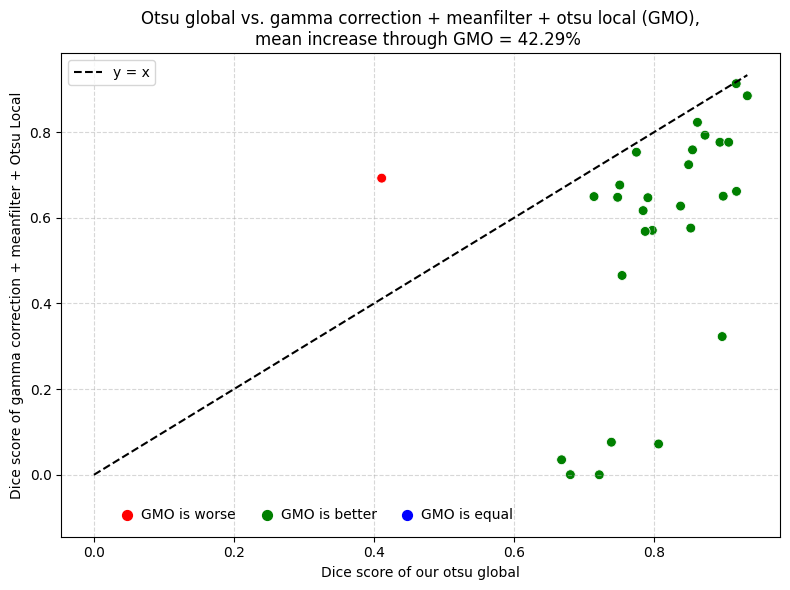

In [12]:
from src.Dice_Score_comparison import calculate_dice_scores_gamma_meanfilter_local_package

# apply gamma_meanfilter and local_package otsu thresholding on all images and calculate dice scores of each dataset 
dice_scores_NIH3T3_gamma_meanfilter_local_package = calculate_dice_scores_gamma_meanfilter_local_package(imgs_NIH3T3, gts_NIH3T3,  radius=150)
dice_scores_N2DL_HeLa_gamma_meanfilter_local_package = calculate_dice_scores_gamma_meanfilter_local_package(imgs_N2DL_HeLa, gts_N2DL_HeLa, radius=125)
dice_scores_N2DH_GOWT1_gamma_meanfilter_local_package = calculate_dice_scores_gamma_meanfilter_local_package(imgs_N2DH_GOWT1, gts_N2DH_GOWT1, radius=450)

# vector with all dice score of gamma_meanfilter + local_package otsu thresholding
all_dice_scores_gamma_meanfilter_local_package =  dice_scores_N2DH_GOWT1_gamma_meanfilter_local_package + dice_scores_N2DL_HeLa_gamma_meanfilter_local_package + dice_scores_NIH3T3_gamma_meanfilter_local_package

# Calculate the relative mean improvement in Dice score when using gamma correction combined with local Otsu thresholding, compared to global Otsu.
mean_increase_global_gamma_meanfilter_local_package = (np.mean(np.array(all_dice_scores_gamma_meanfilter_local_package))-np.mean(np.array(dice_all_global)))/np.mean(np.array(dice_all_global))

# Calculate and print improvements separately for each dataset
mean_increase_gowt1_global_gamma_meanfilter_local_package = (np.mean(np.array(dice_scores_N2DH_GOWT1_gamma_meanfilter_local_package))-np.mean(np.array(dice_all_global)))/np.mean(np.array(dice_all_global))
mean_increase_hela_global_gamma_meanfilter_local_package = (np.mean(np.array(dice_scores_N2DL_HeLa_gamma_meanfilter_local_package))-np.mean(np.array(dice_all_global)))/np.mean(np.array(dice_all_global))
mean_increase_nih_global_gamma_meanfilter_local_package = (np.mean(np.array(dice_scores_NIH3T3_gamma_meanfilter_local_package ))-np.mean(np.array(dice_all_global)))/np.mean(np.array(dice_all_global))

print("Increase of Dice score of GOWT1 =", f"{mean_increase_gowt1_global_gamma_meanfilter_local_package * 100:.2f}%")
print("Increase of Dice score of HeLa =", f"{mean_increase_hela_global_gamma_meanfilter_local_package * 100:.2f}%")
print("Increase of Dice score of NIH3T3 =", f"{mean_increase_nih_global_gamma_meanfilter_local_package * 100:.2f}%") 

# plot of package otsu local with gamma correction, meanfilter and best median radius for each dataset against otsu global 
scatterplot_without_regression(
    all_dice_scores_gamma_meanfilter_local_package,
    dice_all_global,
    xlabel="Dice score of our otsu global",
    ylabel="Dice score of gamma correction + meanfilter + Otsu Local",
    title=f"Otsu global vs. gamma correction + meanfilter + otsu local (GMO),\nmean increase through GMO = {mean_increase_global_gamma_meanfilter_local_package* 100:.2f}% ", 
    label_red = "GMO is worse",
    label_green = "GMO is better",
    label_blue = "GMO is equal"
)

**Visual Evidence**

- Agreement between our implementations and scikit-image for both global and local Otsu, validating correctness.
- Clear performance gains for local Otsu (especially with optimal median radii) over global thresholding.
- Significant improvement when adding gamma correction, with most images showing large Dice score increases.
- Boxplots of optimal radii per dataset confirm median-based strategies are statistically robust choices for selecting window sizes in local thresholding.

These results demonstrate that while local Otsu alone offers a modest improvement over global thresholding, tuning window radii—and especially combining with gamma correction, can dramatically enhance segmentation, which is essential for challenging fluorescence microscopy images.

## 8. Conclusion: Summarizing Findings and Practical Insights

In this project, we systematically implemented and evaluated Otsu-based segmentation methods for cell nuclei in fluorescence microscopy images. Our extensive analyses revealed the following key insights:

- **Validation of Implementations:** Our global and local Otsu implementations were thoroughly validated against standard `scikit-image` and `medpy.metric` package methods, showing near-identical Dice scores, confirming correctness.

- **Global vs. Local Thresholding:** Local Otsu thresholding outperformed global Otsu when the window radius was tuned per dataset, with a mean Dice improvement of +3.47% when using median optimal radii. However, mean radii were less robust due to sensitivity to outliers.

- **Effect of Pre-Processing:** Applying gamma correction (γ=0.6) before local Otsu significantly enhanced segmentation performance, achieving a mean Dice score increase of +29.44% over local Otsu alone and +33.93% over global Otsu. This confirms gamma correction’s effectiveness at improving nucleus-to-background contrast.

- **Multi-Otsu Limitations:** Multi-Otsu thresholding, even with artifact cleaning and small object removal, showed inconsistent results on NIH3T3 images with bright flashes. Its performance varied widely across images, indicating limited utility for robust segmentation under these conditions.

- **Optimal Radius Determination:** Analysis of optimal window radii across datasets highlighted clear trends matching biological differences: large, sparse nuclei (GOWT1) favored larger radii, while small, dense nuclei (HeLa and NIH3T3) required smaller radii. Median radii proved to be more reliable than means due to reduced sensitivity to extreme cases.

- **Final Recommendation:** Our final pipeline combining gamma correction with local Otsu (using median optimal radii) consistently outperformed all other methods. It provides a simple yet powerful approach for robust, automated segmentation of cell nuclei across diverse fluorescence microscopy datasets.

Overall, our study demonstrates that careful parameter optimization (e.g., radius selection) and pre-processing (gamma correction) are critical to maximizing segmentation performance with Otsu-based methods, and that local thresholding with tuned parameters can substantially improve segmentation quality in challenging biomedical images.
